<figure>
    <img class="center-fit" src="https://raw.githubusercontent.com/mabebt2b/TIA-AG/main/BAgTiP_Banner_4.png" alt="logo"/>
</figure>

# <span style="color:#2F5597">COVID-19: Análisis de un catálogo de datos<br></span>

<div style="background-color:#EBEBEB; padding:10px 15px;border:1px solid #CBCBCB; color:#3B3B3B">
    <span><b>Autores:</b><br>María Belén <b>B</b>enalcázar Tovar<br>Daniel <b>Ag</b>uilar Noblecilla<br>Patricia Katherine <b>Ti</b>grero Quimi<br>Edith <b>P</b>érez Tatamués<br>Cri<b>s</b>tian Jacinto Guanín Pilco<br><br>
    <b>Fecha:</b> 4 de febrero de 2022<br>
        <font size=-2><b>UNIR|Máster en Big Data y Visual Analytics</b></font></span>
</div>

---

## Resumen
Gracias a las diferentes técnicas de análisis de datos y aprendizaje automático es posible identificar el _Impacto de la pandemia COVID-19 a nivel global_. El presente estudio pretende ***determinar los países más afectados durante la pandemia y establecer un esquema de impacto a nivel mundial en el año 2020***.

Para dicho análisis se ha usado de base el dataset ***covid_total.csv***, tomado de [Data Europa](https://data.europa.eu/data/datasets/covid-19-coronavirus-data/?locale=es), pero por facilidad para la importación se lo ha cargado en un repositorio de [GitHub](https://github.com/mabebt2b/TIA-AG/blob/main/covid_global.csv). Esta información se ha complementado con  el dataset ***owid-covid-data.csv*** tomado del portal [OurWorldInData](https://github.com/owid/covid-19-data/tree/master/public/data/) y un dataset transformado que toma como referencia los datasets diarios la [CSSE JHU](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data).

Se aplicará una técnica de agrupamiento usando clúster para evaluar el impacto de la pandemia en los diferentes paises del mundo. Con dichos resultados se probará el correcto agrupamiento usando algoritmos de clasificación.

## Importación de librerías e inicialización

Para hacerlo compatible con cualquier entorno, se conserva la línea del ejercicio provisto en clases, previniendo problemas con los certificados en Mac, para importar los ficheros de forma segura.

In [197]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

Se cargan las librerías necesarias para todo el ejercicio:

In [343]:
# Librerías generales
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from numpy import unique
from numpy import where
# Módulos Scikit Learn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# Clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from kmodes.kprototypes import KPrototypes
from fcmeans import FCM
# Módulos geográficos
import geopandas as gpd
import geoplot as gplt
# Módulos para series temporales
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans as tsKMeans

Se ignoran los warnings

In [199]:
import warnings
warnings.filterwarnings('ignore')

Se deshabilita el autoscroll para mostrar los gráficos de mejor manera.

In [200]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Preparación de los datos

### Dataset base
Cargamos el dataset base desde su *url pública* en [GitHub](https://github.com/mabebt2b/TIA-AG/blob/main/covid_global.csv) y lo leemos usando pandas, identificando los campos vacíos como nulos y previniendo que las columnas con el texto "NA" se tomen como nulas.

In [201]:
url = "https://raw.githubusercontent.com/mabebt2b/TIA-AG/main/covid_global.csv"
ds = pd.read_csv(url,keep_default_na=False,na_values=[""])

El dataset inicial posee **12 atributos**, varios de ellos poseen valores nulos. Existen campos categóricos y numéricos.

In [202]:
ds.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
0,14/12/2020,14,12,2020,746,6,Afghanistan,AF,AFG,38041757.0,Asia,9.013779
1,13/12/2020,13,12,2020,298,9,Afghanistan,AF,AFG,38041757.0,Asia,7.052776
2,12/12/2020,12,12,2020,113,11,Afghanistan,AF,AFG,38041757.0,Asia,6.868768
3,11/12/2020,11,12,2020,63,10,Afghanistan,AF,AFG,38041757.0,Asia,7.134266
4,10/12/2020,10,12,2020,202,16,Afghanistan,AF,AFG,38041757.0,Asia,6.968658


In [203]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61900 entries, 0 to 61899
Data columns (total 12 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   dateRep                                                     61900 non-null  object 
 1   day                                                         61900 non-null  int64  
 2   month                                                       61900 non-null  int64  
 3   year                                                        61900 non-null  int64  
 4   cases                                                       61900 non-null  int64  
 5   deaths                                                      61900 non-null  int64  
 6   countriesAndTerritories                                     61900 non-null  object 
 7   geoId                                                       61900 non-null  object 
 

Se prepara el dataset para el análisis, en primera instancia se transforma a fecha el campo ***dateRep***.
>El período de datos del presente dataset abarca desde el **31 de diciembre de 2019 hasta el 14 de diciembre de 2020**.

In [204]:
ds["dateRep"]=pd.to_datetime(ds["dateRep"])

In [205]:
print("\033[1mRango de fechas: \033[0m",min(ds["dateRep"]), max(ds["dateRep"]))

Rango de fechas:  2019-12-31 00:00:00 2020-12-14 00:00:00


Se evalúan las columnas tipo _object_ para determinar su estructura.
>Estas cuatro columnas son de tipo categórico, poseen un conjunto de valores limitados. Tres de ellos: ***countriesAndTerritories***, ***geoId*** y ***countryterritoryCode*** están relacionados con el país del que se almacenan los datos. El atributo ***countryterritoryCode***, que contiene los códigos de los países, posee menos categorías y tiene valores nulos por lo que se debe considerar la limpieza del dataset tomando como referencia esta columna.

In [206]:
print(ds.describe(include=["object"]))

       countriesAndTerritories  geoId countryterritoryCode continentExp
count                    61900  61900                61777        61900
unique                     214    214                  212            6
top                South_Korea     KR                  KOR       Europe
freq                       350    350                  350        17372


Se eliminan los valores nulos tomando como referencia la columna que contiene los códigos de países: ***countryterritoryCode***.

In [207]:
ds=ds.dropna(subset=["countryterritoryCode"])
print(ds.shape)

(61777, 12)


In [208]:
# Respaldo del dataset original previo la union con otros datasets.
ds_origin = ds

In [209]:
# Se define el campo que se usará como referencia
code="countryterritoryCode"

### Datasets adicionales

Con el objetivo de obtener más parámetros para el estudio planteado, se usan dos datasets públicos adicionales. Se realiza la unión de los datasets usando pandas <a name="ref-1"/>[(Pandas, 2022)](#cite-pd-merge).

#### Dataset de Our World In Data
Uno de los datasets usados para complementar el análisis se ha tomado del portal <a name="ref-2"/>[(OurWorldInData, 2022)](#cite-OWID-GH), con información detallada a nivel mundial de COVID-19. Este dataset posee ***159781 instancias*** y ***67 campos***, existe gran cantidad de datos nulos en la columnas. Solamente se seleccionan aquellos campos relevantes para el presente análisis y cuya informacion no reduzca excesivamente el numero de instancias del dataset original.

In [210]:
url_aux = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"
ds_aux = pd.read_csv(url_aux)

In [211]:
ds_aux.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161909 entries, 0 to 161908
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    161909 non-null  object 
 1   continent                                   152200 non-null  object 
 2   location                                    161909 non-null  object 
 3   date                                        161909 non-null  object 
 4   total_cases                                 158958 non-null  float64
 5   new_cases                                   158930 non-null  float64
 6   new_cases_smoothed                          157779 non-null  float64
 7   total_deaths                                141289 non-null  float64
 8   new_deaths                                  141461 non-null  float64
 9   new_deaths_smoothed                         141331 non-null  float64
 

Las columnas necesarias para el análisis se consideran: ***iso_code***, ***location*** y ***date*** (para la union con el dataset original), ***reproduction_rate, icu_patients, hosp_patients, stringency_index, median_age, extreme_poverty,  cardiovasc_death_rate,diabetes_prevalence, handwashing_facilities, life_expectancy,  human_development_index, excess_mortality***.

In [212]:
ds_aux=ds_aux[ds_aux.columns[[0,2,3,16,17,19,47,50,54,55,56,59,61,62,65]]]

In [213]:
ds_aux.head()

,iso_code,location,date,reproduction_rate,icu_patients,hosp_patients,stringency_index,median_age,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,handwashing_facilities,life_expectancy,human_development_index,excess_mortality
0,AFG,Afghanistan,2020-02-24,NaN,NaN,NaN,8.33,18.6,NaN,597.029,9.59,37.746,64.83,0.511,NaN
1,AFG,Afghanistan,2020-02-25,NaN,NaN,NaN,8.33,18.6,NaN,597.029,9.59,37.746,64.83,0.511,NaN
2,AFG,Afghanistan,2020-02-26,NaN,NaN,NaN,8.33,18.6,NaN,597.029,9.59,37.746,64.83,0.511,NaN
3,AFG,Afghanistan,2020-02-27,NaN,NaN,NaN,8.33,18.6,NaN,597.029,9.59,37.746,64.83,0.511,NaN
4,AFG,Afghanistan,2020-02-28,NaN,NaN,NaN,8.33,18.6,NaN,597.029,9.59,37.746,64.83,0.511,NaN


In [214]:
ds_aux["date"]=pd.to_datetime(ds_aux["date"])

Se verifican los campos por los cuales se realizara la unión: ***countryterritoryCode*** para el dataset original y el campo ***iso_code*** para el dataset auxiliar.
> Existen _7 codigos de país_ del dataset original que no se encuentran en el dataset auxiliar. Se realiza una evaluación para determinar si es posible realizar correcciones previo a la unión de los datasets. El resultado revela que es posible corregir 3 paises.

In [215]:
nofindCodes = [i for i in ds[code].unique() if i not in ds_aux["iso_code"].unique()]
print(nofindCodes)

['GUM', 'XKX', 'MSF', 'MNP', 'PRI', 'CNG1925', 'VIR', 'ESH']


In [216]:
# se crea un dataset solamente con los valores unicos de paises para evaluar si esta en el listado no encontrado
ds_temp=ds.drop_duplicates(["countriesAndTerritories", code])[["countriesAndTerritories", code]]

# se realiza una union del dataset anterior para evaluar si alguno posee el mismo nombre de pais pero diferente codigo
ds_temp=pd.merge(ds_temp[ds_temp[code].isin(nofindCodes)],
         ds_aux.drop_duplicates(["location", "iso_code"])[["location", "iso_code"]],
         left_on=["countriesAndTerritories"],right_on=["location"],
         how='left',indicator=False).drop(columns="location").dropna()
ds_temp

,countriesAndTerritories,countryterritoryCode,iso_code
1,Kosovo,XKX,OWID_KOS
2,Montserrat,MSF,MSR
5,Taiwan,CNG1925,TWN


In [217]:
for row in ds_temp.index:
    ds_aux.loc[ds_aux["iso_code"] == ds_temp["iso_code"][row], "iso_code"] = ds_temp[code][row]

Una vez corregidos los códigos de país, se realiza la unión del dataset original con el dataset auxiliar.

In [218]:
ds=pd.merge(ds,ds_aux,left_on=["dateRep",code], 
         right_on=["date","iso_code"],how='left',indicator=False).drop(columns=["date","iso_code","location"])

In [219]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61777 entries, 0 to 61776
Data columns (total 24 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   dateRep                                                     61777 non-null  datetime64[ns]
 1   day                                                         61777 non-null  int64         
 2   month                                                       61777 non-null  int64         
 3   year                                                        61777 non-null  int64         
 4   cases                                                       61777 non-null  int64         
 5   deaths                                                      61777 non-null  int64         
 6   countriesAndTerritories                                     61777 non-null  object        
 7   geoId                 

#### Dataset de CSSE
Se usan tambien los datos de <a name="ref-3"/>[(CSSEJHU, 2022)](#cite-CSSE-JHU) para obtener los campos ***Incident_Rate*** y ***Case_Fatality_Ratio***. Se realiza una unión por el nombre de país en este caso. 
>El dataset posee información de 239 países. Al ser tasas ya calculadas se usarán para tener una visión global del problema, más no para el entrenamiento de algoritmos.

In [220]:
url_aux = "https://raw.githubusercontent.com/mabebt2b/TIA-AG/main/covid_19_master.csv"
ds_aux = pd.read_csv(url_aux)

In [221]:
ds_aux.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54857 entries, 0 to 54856
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Last_Update          54857 non-null  object 
 1   Country_Region       54857 non-null  object 
 2   Confirmed            54749 non-null  object 
 3   Deaths               54625 non-null  float64
 4   Recovered            48374 non-null  float64
 5   Active               45816 non-null  float64
 6   Incident_Rate        39288 non-null  float64
 7   Case_Fatality_Ratio  39231 non-null  float64
dtypes: float64(5), object(3)
memory usage: 3.3+ MB


In [222]:
ds_aux["Country_Region"].describe()

count     54857
unique      239
top       China
freq        334
Name: Country_Region, dtype: object

El dataset no posee información completa de los países. Según la validación, existen 16 países que no constan en el dataset auxiliar.

In [223]:
len([i for i in ds["countriesAndTerritories"].unique() if i not in ds_aux["Country_Region"].unique()])

16

Previo a la unión se realiza una limpieza del dataset auxiliar, transformando el tipo de datos de la columna fecha y eliminando los valores nulos para optimizar el procedimiento posterior.

In [224]:
ds_aux["Last_Update"]=pd.to_datetime(ds_aux["Last_Update"])

In [225]:
ds_aux.drop(ds_aux.columns[2:6], axis=1, inplace=True)

In [226]:
ds_aux.dropna(inplace=True)

Se realiza la unión por los campos fecha (***dateRep***) y país (***countriesAndTerritories***) y sus equivalentes en el dataset auxiliar: ***Last_Update*** y ***Country_Region*** respectivamente.

In [227]:
ds=pd.merge(ds,ds_aux,left_on=["dateRep","countriesAndTerritories"],
            right_on=["Last_Update","Country_Region"],
            how='left',indicator=False).drop(columns=["Last_Update","Country_Region"])

Se evalúa la forma del dataset resultante si se eliminaran los datos nulos.
> Se puede observar que no se tendría ninguna fila, es decir todas las filas contienen al menos un valor nulo, por lo que se realizará primero un análisis exploratorio del dataset para determinar los campos que se usarán para el estudio. Otros campos permitirán clarificar el desarrollo de la pandemia aunque no se usen para los algoritmos de entrenamiento.

In [228]:
ds.dropna().shape

(0, 26)

In [229]:
ds.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,...,median_age,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,handwashing_facilities,life_expectancy,human_development_index,excess_mortality,Incident_Rate,Case_Fatality_Ratio
0,2020-12-14,14,12,2020,746,6,Afghanistan,AF,AFG,38041757.0,...,18.6,NaN,597.029,9.59,37.746,64.83,0.511,NaN,NaN,NaN
1,2020-12-13,13,12,2020,298,9,Afghanistan,AF,AFG,38041757.0,...,18.6,NaN,597.029,9.59,37.746,64.83,0.511,NaN,NaN,NaN
2,2020-12-12,12,12,2020,113,11,Afghanistan,AF,AFG,38041757.0,...,18.6,NaN,597.029,9.59,37.746,64.83,0.511,NaN,NaN,NaN
3,2020-11-12,11,12,2020,63,10,Afghanistan,AF,AFG,38041757.0,...,18.6,NaN,597.029,9.59,37.746,64.83,0.511,NaN,NaN,NaN
4,2020-10-12,10,12,2020,202,16,Afghanistan,AF,AFG,38041757.0,...,18.6,NaN,597.029,9.59,37.746,64.83,0.511,NaN,NaN,NaN


#### Dataset geográfico
Se usa además un dataset geográfico que ya posee la geometría definida para poder realizar los gráficos de coropletas y visualizar la distribución de los países. Para ello se usa Geopandas y un dataset de esta librería <a name="ref-4"/>[(Geopandas, 2022)](#cite-GPD:2022)

In [241]:
world = gpd.read_file("https://raw.githubusercontent.com/mabebt2b/TIA-AG/main/countries.geojson")

In [242]:
world.head(2)

,scalerank,featurecla,labelrank,sovereignt,sov_a3,adm0_dif,level,type,admin,adm0_a3,...,continent,region_un,subregion,region_wb,name_len,long_len,abbrev_len,tiny,homepart,geometry
0,3,Admin-0 country,5.0,Netherlands,NL1,1.0,2.0,Country,Aruba,ABW,...,North America,Americas,Caribbean,Latin America & Caribbean,5.0,5.0,5.0,4.0,-99.0,"POLYGON ((-69.89912 12.45200, -69.89570 12.423..."
1,1,Admin-0 country,3.0,Afghanistan,AFG,0.0,2.0,Sovereign country,Afghanistan,AFG,...,Asia,Asia,Southern Asia,South Asia,11.0,11.0,4.0,-99.0,1.0,"POLYGON ((74.89131 37.23164, 74.84023 37.22505..."
2,1,Admin-0 country,3.0,Angola,AGO,0.0,2.0,Sovereign country,Angola,AGO,...,Africa,Africa,Middle Africa,Sub-Saharan Africa,6.0,6.0,4.0,-99.0,1.0,"MULTIPOLYGON (((14.19082 -5.87598, 14.39863 -5..."


In [266]:
world.shape

(241, 5)

Se conservan únicamente las columnas necesarias de este dataset. Ya que solo se usará para propósitos gráficos, se requieren las columnas ***iso_a3***, que contiene el código del país para la unión con otros datasets y ***geometry***

In [265]:
world=world[["iso_a3","name","continent","region_un","geometry"]]

El dataset posee solamente 241 países frente a 212 que son motivo del análisis, pero existen países que tienen la geometría pero no se encuentran en el dataset original por código, por lo que se realiza primero la correción en este dataset geográfico, tomando como referencia la columna del nombre de los países para la correción del campo ***iso_a3***.
>Es posible corregir los códigos de 4 países.

In [267]:
iso_problem=[i for i in world["iso_a3"].unique() if i not in ds[code].unique()]
ds_temp=world[world["iso_a3"].isin(iso_problem)][["continent","name","iso_a3"]]

In [268]:
ds_temp=pd.merge(ds_temp,ds[["countriesAndTerritories", code]].groupby(["countriesAndTerritories", code]).count().reset_index(),
                         left_on=["name"],right_on=["countriesAndTerritories"],
                         how='inner',indicator=False).drop(columns="countriesAndTerritories")
ds_temp

,continent,name,iso_a3,countryterritoryCode
0,Europe,Kosovo,-99,XKX
1,North America,Montserrat,MSR,MSF
2,Asia,Taiwan,TWN,CNG1925


In [269]:
for row in ds_temp.index:
    world.loc[world["name"] == ds_temp["name"][row], "iso_a3"] = ds_temp[code][row]

Se evalúa cuáles son los países del dataset base de los que no se posee la geometría.
>Se encuentran solament 2 países. Por lo que la gráfica con 210 se considera adecuada.

In [270]:
noGeometry = [i for i in ds[code].unique() if i not in world["iso_a3"].unique()]
print(noGeometry)

['BES', 'GIB']


## Evaluación del dataset
### Limpieza preliminar del dataset
Tras la unión de los dataset se analiza el conjunto de datos a detalle.
>El dataset posee **61777 instancias** y **26 atributos**: uno de tipo fecha, 21 de tipo numérico y 4 de tipo categórico. 

>Se analiza el contexto de los atributos de entrada para poder realizar un correcto análisis:
>- **dateRep:** fecha de los datos.
>- **day, month, year:** campos día, mes y año, correspondientes a la fecha.
>- **cases:** nuevos casos diarios.
>- **deaths:** nuevas muertes diarias.
>- **countriesAndTerritories:** países y territorios de los datos.
>- **popData2019:** dato de población al 2019.
>- **continentExp:** continente.
>- **Cumulative_number_for_14_days_of_COVID-19_cases_per_100000:** número de casos acumulado cada 14 días por cada 100000 habitantes.
>- **reproduction_rate:** taza de reproducción.
>- **icu_patients:** pacientes cuidados intensivos.
>- **hosp_patients:** pacientes hospitalizados.
>- **positive_rate:** tasa de casos positivos.
>- **stringency_index:** índice de restricciones.
>- **median_age:** edad promedio.
>- **extreme_poverty:** índice de pobreza extrema.
>- **cardiovasc_death_rate:** muertes por enfermedades cardiovasculares.
>- **diabetes_prevalence:** índice de prevalencia de diabetes.
>- **handwashing_facilities:** cantidad de facilidades de limpieza.
>- **life_expectancy:** promedio de expectativa de vida.
>- **human_development_index:** índice de desarrollo humano.
>- **excess_mortality:** incremento de mortalidad.
>- **Incident_Rate:** tasa de incidencia del COVID-19
>- **Case_Fatality_Ratio:** tasa de mortalidad de COVID-19.

In [286]:
print("Forma del dataset:",ds.shape)

Forma del dataset: (61777, 26)


Se analiza el tipo de datos de cada columna y la cantidad de datos nulos.
> Los campos ***excess_mortality***, ***Incident_Rate*** y ***Case_Fatality_Ratio*** son los que más datos nulos presentan, seguidos de ***icu_patients*** y ***hosp_patients***, por lo que se realiza un análisis más detallado de los atributos, para conocer información de cuántos países poseen y así determinar si contribuirían al análisis. 

In [287]:
print(ds.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61777 entries, 0 to 61776
Data columns (total 26 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   dateRep                                                     61777 non-null  datetime64[ns]
 1   day                                                         61777 non-null  int64         
 2   month                                                       61777 non-null  int64         
 3   year                                                        61777 non-null  int64         
 4   cases                                                       61777 non-null  int64         
 5   deaths                                                      61777 non-null  int64         
 6   countriesAndTerritories                                     61777 non-null  object        
 7   geoId                 

En base a los resultados se considera eliminar del análisis los campos que poseen menos de 150 países: ***icu_patients***, ***hosp_patients***, ***extreme_poverty***,***handwashing_facilities*** y ***excess_mortality***.

In [288]:
eval_col=["icu_patients", "hosp_patients","stringency_index","median_age","","excess_mortality", "Incident_Rate", "Case_Fatality_Ratio"]
for col in ds.columns[12:]:
    print(col,"-",ds[["countriesAndTerritories",col]].dropna()["countriesAndTerritories"].nunique(),"países")

reproduction_rate - 177 países
icu_patients - 35 países
hosp_patients - 36 países
stringency_index - 177 países
median_age - 183 países
extreme_poverty - 123 países
cardiovasc_death_rate - 184 países
diabetes_prevalence - 192 países
handwashing_facilities - 94 países
life_expectancy - 203 países
human_development_index - 182 países
excess_mortality - 108 países
Incident_Rate - 180 países
Case_Fatality_Ratio - 180 países


In [289]:
ds.drop(["icu_patients", "hosp_patients","extreme_poverty","handwashing_facilities","excess_mortality"],axis=1,inplace=True)

Se eliminan también las columnas auxiliares de fecha: **day**, **month**, **year** por no presentar relevancia para el modelo. Y los atributos ***countriesAndTerritories*** y ***geoId***, ya que poseen redundancia con el código del atributo ***countryterritoryCode***.

In [290]:
ds.drop(["day", "month", "year","countriesAndTerritories","geoId"],axis=1,inplace=True)

Se convienten a categóricos los campos de tipo objeto que se evaluaron en la preparación de datos.

In [291]:
for col in ds:
    if ds[col].dtypes == "object":
        ds[col]=ds[col].astype("category")
cat_attributes=list(ds.select_dtypes(include="category").columns)

In [292]:
print(ds.dtypes)

dateRep                                                       datetime64[ns]
cases                                                                  int64
deaths                                                                 int64
countryterritoryCode                                                category
popData2019                                                          float64
continentExp                                                        category
Cumulative_number_for_14_days_of_COVID-19_cases_per_100000           float64
reproduction_rate                                                    float64
stringency_index                                                     float64
median_age                                                           float64
cardiovasc_death_rate                                                float64
diabetes_prevalence                                                  float64
life_expectancy                                                      float64

Se cambia el nombre de la columna ***Cumulative_number_for_14_days_of_COVID-19_cases_per_100000*** por uno más manejable en dimensión.

In [293]:
ds = ds.rename(columns={"Cumulative_number_for_14_days_of_COVID-19_cases_per_100000": "cases_14d_100K"})

Se validan si existen duplicados del dataset. Tras dicha operación el dataset conserva su forma, por lo que se deduce que no existen filas repetidas.

In [294]:
ds.drop_duplicates(inplace=True)
print(ds.shape)

(61777, 16)


Tras la limpieza preliminar, si se eliminan todos los nulos del actual dataset se podría realizar el análisis de 155 países. Sin embargo se conservan aún las columnas.

In [295]:
ds.dropna()[code].nunique()

155

### Análisis exploratorio de datos

Se analizan los rangos de las variables numéricas.
>De las estadísticas se puede observar que los atributos ***cases*** y ***deaths*** tienen valores negativos, que no concuerda con los valores requeridos. La existencia de valores negativos se debe a que varios países reportan los valores acumulados y tras examinar los registros médicos muchas veces ese valor disminuye dando como resultado un valor de casos o muertes negativas <a name="ref-5"/>[(ScienceDirect, 2021)](#cite-COVID-NEGATIVE). Para corregir ese particular se realiza una corrección realizando el cambio a cero del día negativo y se resta el valor de las filas anteriores hasta que el valor sea mayor a cero.

In [296]:
ds.describe()

,cases,deaths,popData2019,cases_14d_100K,reproduction_rate,stringency_index,median_age,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index,Incident_Rate,Case_Fatality_Ratio
count,61777.000000,61777.000000,6.177700e+04,59021.000000,41308.000000,47200.000000,48539.000000,48586.000000,50519.000000,53282.000000,48018.000000,2160.000000,2160.000000
mean,1157.435858,26.107224,4.098770e+07,66.320586,1.047079,59.879103,31.032034,252.894842,7.974495,73.771887,0.733441,136.659482,3.232530
std,6785.775773,131.352497,1.531294e+08,162.329240,0.393354,22.173940,9.125539,118.003996,4.127152,7.462306,0.150512,287.251470,3.362588
min,-8261.000000,-1918.000000,8.150000e+02,-147.419587,-0.020000,0.000000,15.100000,79.370000,0.990000,53.280000,0.394000,0.089415,0.000000
25%,0.000000,0.000000,1.293120e+06,0.757526,0.860000,44.440000,22.900000,156.139000,5.310000,69.660000,0.611000,8.360182,0.899998
50%,16.000000,0.000000,7.169456e+06,6.724045,1.040000,62.500000,30.700000,240.208000,7.110000,75.130000,0.759000,28.199729,2.392751
75%,276.000000,4.000000,2.851583e+07,52.572719,1.230000,77.780000,39.700000,322.688000,10.180000,79.070000,0.852000,140.968339,4.347826
max,234633.000000,4928.000000,1.433784e+09,1900.836210,6.080000,100.000000,48.200000,724.417000,30.530000,86.750000,0.957000,2494.880357,24.838710


In [297]:
def change_negative(ds,column):
    for row in ds[ds[column]<0].index:
        ref=row
        while True:
            ds[column].loc[ref-1]+=ds[column].loc[ref]
            ds[column].loc[ref]=0
            ref-=1
            val=ds[column].loc[ref]
            if (val>=0): break

In [298]:
change_negative(ds,"cases")
change_negative(ds,"deaths")

Se validan nuevamente los valores nulos antes de realizar en análisis gráfico.

In [299]:
ds.isna().sum()

dateRep                        0
cases                          0
deaths                         0
countryterritoryCode           0
popData2019                    0
continentExp                   0
cases_14d_100K              2756
reproduction_rate          20469
stringency_index           14577
median_age                 13238
cardiovasc_death_rate      13191
diabetes_prevalence        11258
life_expectancy             8495
human_development_index    13759
Incident_Rate              59617
Case_Fatality_Ratio        59617
dtype: int64

>Para los atributos ***cases_14d_100K*** y ***reproduction_rate*** que no es sencillo estimar el valor se reemplaza por ceros los valores negativos.

In [300]:
def change_negative_to_zero(ds,column):
    for row in ds[ds[column]<0].index:
        ds[column].loc[row]=0

In [301]:
change_negative_to_zero(ds,"cases_14d_100K")
change_negative_to_zero(ds,"reproduction_rate")

In [302]:
ds[["cases","deaths","cases_14d_100K","reproduction_rate"]].describe()

,cases,deaths,cases_14d_100K,reproduction_rate
count,61777.000000,61777.000000,59021.000000,41308.000000
mean,1157.435858,26.107224,66.353311,1.047082
std,6785.655639,131.020938,162.302140,0.393346
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.757526,0.860000
50%,15.000000,0.000000,6.724045,1.040000
75%,275.000000,4.000000,52.572719,1.230000
max,234633.000000,4928.000000,1900.836210,6.080000


Con el objetivo de conservar la mayor cantidad de datos y su confiabilidad, para los campos que contienen el cálculo de tasas y cuyos valores tienden a ser constantes por países: (***reproduction_rate***, ***stringency_index***, ***median_age***, ***cardiovasc_death_rate***, ***diabetes_prevalence***, ***life_expectancy***, ***human_development_index***), se realiza una interpolación para completarlos por país.

In [303]:
# se definen las columnas sobre las cuales se realiza la interpolación
interpolate_columns=ds.columns[7:14].values
for country in ds[code].unique():
    for column in interpolate_columns:
        ds.loc[ds[code]==country,column]=ds[ds[code]==country][column].interpolate(limit_direction="both",limit=10)

Tras la interpolación aún existen valores nulos, esto se debe a que existen países de los cuales no se poseen datos. Se rellena esos campos con cero.

In [304]:
ds[interpolate_columns].isna().sum()

reproduction_rate          9663
stringency_index           9228
median_age                 7704
cardiovasc_death_rate      7647
diabetes_prevalence        5430
life_expectancy            2407
human_development_index    8267
dtype: int64

In [305]:
ds[interpolate_columns]=ds[interpolate_columns].replace(np.nan,0)

Se calcula el **coeficiente de variación** de los atributos de entrada.
>La variación de ***cases*** y ***deaths*** es similar. Seguido del atributo que representa la población ***popData2019***, esto es coherente ya que la cantidad de población de los países tiene amplia variación.

In [306]:
# Cálculo del coeficiente de variación
print("\033[1mCoeficiente de Variación:\033[0m")
for col in ds:
    if pd.api.types.is_numeric_dtype(ds[col]):
        print(col,ds[col].std()/abs(ds[col].mean()))

Coeficiente de Variación:
cases 5.862662360075597
deaths 5.018570187661431
popData2019 3.735983867249276
cases_14d_100K 2.446029240603605
reproduction_rate 0.5976948661842763
stringency_index 0.5894816825009646
median_age 0.49108073001223307
cardiovasc_death_rate 0.6249787600393121
diabetes_prevalence 0.6272343377044534
life_expectancy 0.22633234806866062
human_development_index 0.45076773327078656
Incident_Rate 2.1019505223667476
Case_Fatality_Ratio 1.0402339799096911


Se grafica la evolución de casos y de muertes - acumulados - agrupados por país, con el objetivo de tener una visión global del comportamiento <a name="ref-6"/>[(LOST, 2022)](#cite-LOST)
>Las gráficas muestran que existen pocos países que sobresalen en el acumulado. Ls países con más casos son: Estados Unidos, India y Brasil. Para las muertes sobresalen: Estados Unidos, Brasil, India y México. Sin embargo estos son valores absolutos (no tienen en cuenta la población de cada país), por lo que no serían los únicos necesarios para determinar el impacto.

In [307]:
# definición de campos esenciales para los gráficos
color=["#2F5597","#D69F17","#002060","#FFC000"] # color del tema
cmap="cividis_r"
mpl.rc('image', cmap=cmap)
sns.set_palette(cmap)

In [308]:
ds_evolution=ds.groupby([code, "dateRep"])["cases","deaths","cases_14d_100K"].sum().groupby(level=0).cumsum().reset_index()

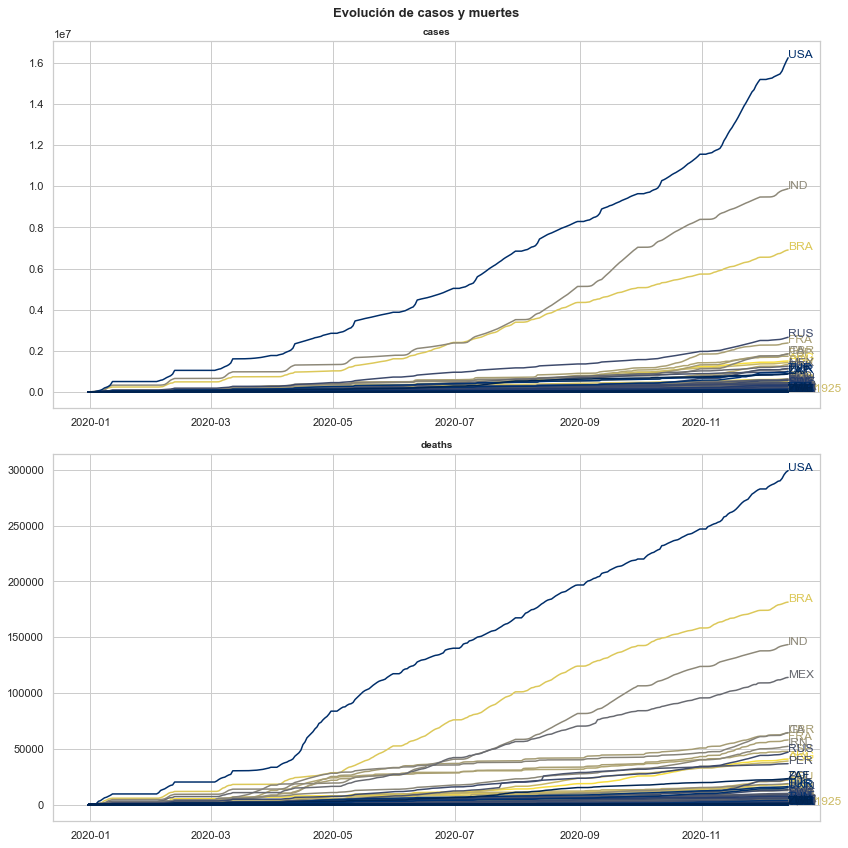

In [90]:
sns.set(rc={'figure.figsize':(12,12)})
sns.set_style("whitegrid")
fig,axes = plt.subplots(2,1)
fig.suptitle('Evolución de casos y muertes',fontweight ="bold", fontsize="13")

i=0
for col in ["cases","deaths"]:
    ax=sns.lineplot(data=ds_evolution,x="dateRep",y=col,hue=code,palette=cmap,ax=axes[i],legend=False)
    axes[i].set_title(col,fontweight ="bold",fontsize="10")
    axes[i].set(xlabel=None,ylabel=None)
    i+=1
    # Se añade texto para cada línea
    for line, name in zip(ax.lines, ds_evolution[code].unique().tolist()):
        y = line.get_ydata()[-1]
        x = line.get_xdata()[-1]     
        text = ax.annotate(name,xy=(x, y),xytext=(0, 0),color=line.get_color(),
                           xycoords=(ax.get_xaxis_transform(),ax.get_yaxis_transform()),textcoords="offset points")
        text_width = (text.get_window_extent(fig.canvas.get_renderer()).transformed(ax.transData.inverted()).width)
        if np.isfinite(text_width):
            ax.set_xlim(ax.get_xlim()[0], text.xy[0] + text_width * 1.05)
fig.tight_layout()
plt.show()

>Al graficar el atributo ***cases_14d_100K*** se observa un comportamiento diferente al de los valores absolutos.Existe más variación y solamente sobresale Andorra, seguido por Luxemburgo y Montengro.

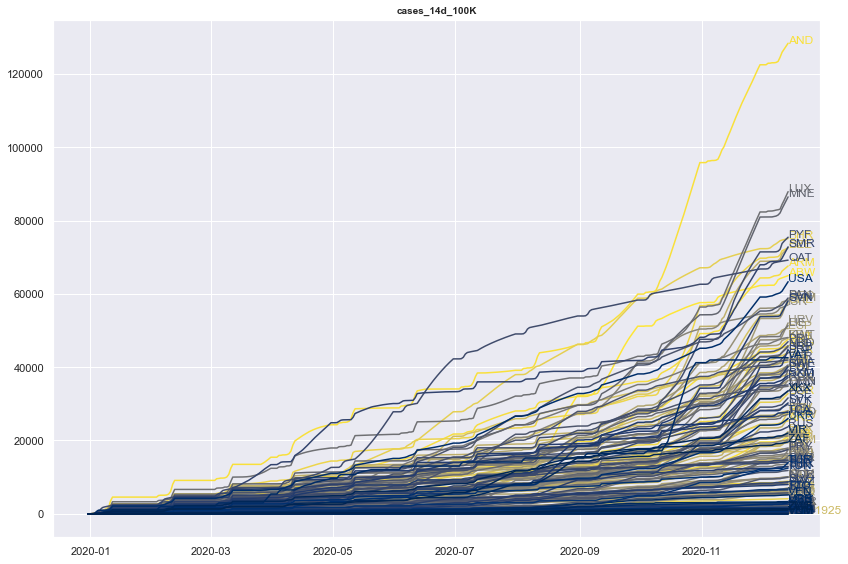

In [163]:
sns.set(rc={'figure.figsize':(12,8)})
col="cases_14d_100K"
fig,axes = plt.subplots(1,1)
ax=sns.lineplot(data=ds_evolution,x="dateRep",y=col,hue=code,palette=cmap,ax=axes,legend=False)
axes.set_title(col,fontweight ="bold",fontsize="10")
axes.set(xlabel=None,ylabel=None)

i+=1
# Se añade texto para cada línea
for line, name in zip(ax.lines, ds_evolution[code].unique().tolist()):
    y = line.get_ydata()[-1]
    x = line.get_xdata()[-1]     
    text = ax.annotate(name,xy=(x, y),xytext=(0, 0),color=line.get_color(),
                       xycoords=(ax.get_xaxis_transform(),ax.get_yaxis_transform()),textcoords="offset points")
    text_width = (text.get_window_extent(fig.canvas.get_renderer()).transformed(ax.transData.inverted()).width)
    if np.isfinite(text_width):
        ax.set_xlim(ax.get_xlim()[0], text.xy[0] + text_width * 1.05)
fig.tight_layout()

Se analizan los países con mayor afectación en _número de casos_ y _muertes_. Se una la función ***barplot*** de **seaborn** <a name="ref-7"/>[(Seaborn, 2021)](#cite-seaborn-plot:2021), para tener una mejor visualización que en los gráficos anteriores.

>La gráfica muestra que los países con más muertes no son necesariamente los con más casos, por lo que existen más variables relacionadas con la mortalidad por causa del virus, las cuales se pretende determinar en el presente estudio. Además la variable población marca una diferencia primordial en el análisis de impacto, por lo cual el campo de casos acumulativo ***cases_14d_100K*** muestra países diferentes a los de las gráficas de los valores absolutos.

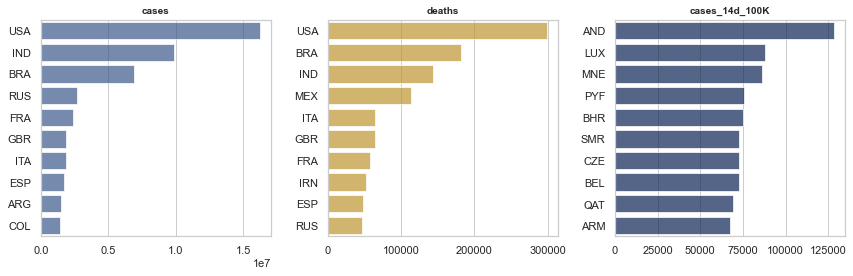

In [92]:
# Configuración área gráfica
sns.set(rc={'figure.figsize':(12,4)})
sns.set_style("whitegrid")
fig,axes = plt.subplots(1,3)
# Gráfico con barplot
i=0
for col in ["cases","deaths","cases_14d_100K"]:
    plot_order = ds.groupby(code)[col].sum().sort_values(ascending=False).index.values
    sns.barplot(data=ds,y=code,x=col,color=color[i],alpha=0.7,estimator=sum,ci=0,order=plot_order[:10],ax=axes[i])
    axes[i].set_title(col,fontweight ="bold",fontsize="10")
    axes[i].set(xlabel=None,ylabel=None)
    i+=1
    
fig.tight_layout()
#sns.despine()
plt.show()

Se analiza el promedio de otros factores que pueden incidir en el impacto de la pandemia en cada uno de los países. 
>De este gráfico se puede deducir que los países con mayor índice de restricciones ***stringency_index*** y desarrollo humano ***human_development_index***, no aparecen entre aquellos con mayor impacto de la pandemia.

>Algunos de los países con mayor edad media ***median_age*** y expectativa de vida ***life_expectancy*** están presentes en los países con mayor número de casos detectados y muertes, como es el caso de _Italia_ y _España_; y también con los países de mayor impacto como es el caso de _Andorra_. Por lo que se consideran variables útiles para el análisis.

>Los países con mayores tasas de enfermedades cardiovasculares ***cardiovasc_death_rate*** y diabetes ***diabetes_prevalence*** no aparecen en entre los países con mayor impacto de mortalidad. Pero no se descartan para el análisis.

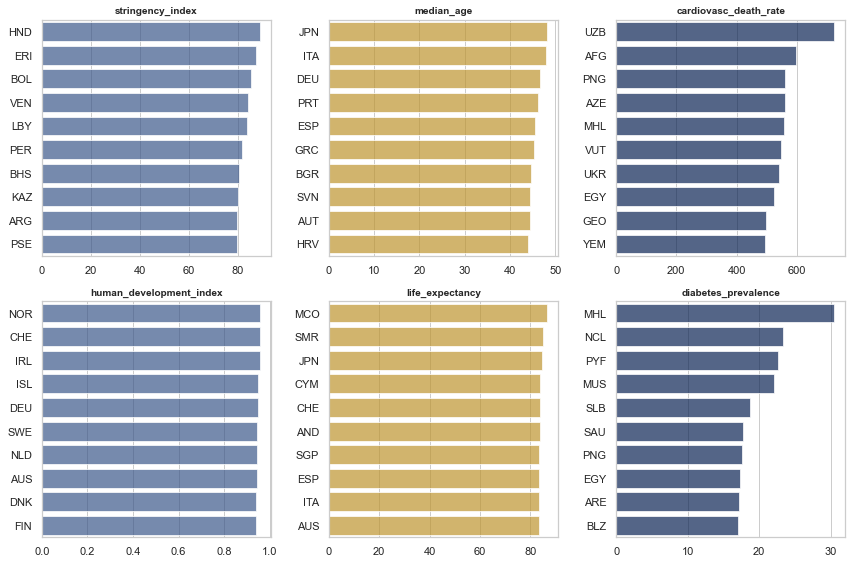

In [93]:
# Configuración área gráfica
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("whitegrid")
fig,axes = plt.subplots(2,3)

# Gráfico con barplot
i=0
for col in ["stringency_index","median_age","cardiovasc_death_rate","human_development_index","life_expectancy","diabetes_prevalence"]:
    plot_order = ds.groupby(code)[col].mean().sort_values(ascending=False).index.values
    sns.barplot(data=ds,y=code,x=col,color=color[i%3],alpha=0.7,ci=0,order=plot_order[:10],ax=axes[i//3,(i)%3])
    axes[i//3,(i)%3].set_title(col,fontweight ="bold",fontsize="10")
    axes[i//3,(i)%3].set(xlabel=None,ylabel=None)
    i+=1
    
fig.tight_layout()
#sns.despine()
plt.show()

Se grafica el top 10 de la taza de incidencia y de mortalidad, como ya se ha mencionado estos campos solamente se usan para proporcionar una idea más clara del agrupamiento y clasificación posteriores. Aunque no se utilizarán estos campos para el análisis por la cantidad de datos nulos que poseen.

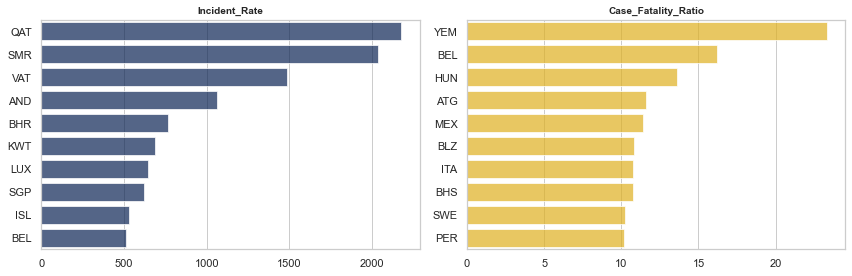

In [51]:
# Configuración área gráfica
sns.set(rc={'figure.figsize':(12,4)})
sns.set_style("whitegrid")
fig,axes = plt.subplots(1,2)

# Gráfico con barplot
i=0
for col in ["Incident_Rate","Case_Fatality_Ratio"]:
    plot_order = ds.groupby(code)[col].mean().sort_values(ascending=False).index.values
    sns.barplot(data=ds,y=code,x=col,color=color[i+2],alpha=0.7,ci=0,order=plot_order[:10],ax=axes[i])
    axes[i].set_title(col,fontweight ="bold",fontsize="10")
    axes[i].set(xlabel=None,ylabel=None)
    i+=1

fig.tight_layout()
#sns.despine()
plt.show()

Se realiza un gráfico de coropletas con los atributos ***Incident_Rate*** y ***Case_Fatality_Radio***.  Para mejorar la apariencia de los gráficos se consulta la biblioteca de colores de Matplotlib <a name="ref-8"/>[(Matplotlib, 2022)](#cite-MPL-CR)
>El gráfico muesta que la tasa de incidencia en África aparentemente es baja, pero la mortalidad por otra parte incrementa en este continente. En cambio aunque Rusia es un país con incidencia alta no está entre los países con mayor mortalidad.

In [94]:
# Función para crear los gráficos geográficos, siempre con la misma apariencia
def map_plot(ds_map,column,scheme,title):
    sns.set(rc={'figure.figsize':(14,10)})
    sns.set_style("white")
    fig, ax = plt.subplots(1, 1)

    ds_map.plot(column=column,ax=ax,cmap=cmap, scheme=scheme, legend=True,legend_kwds={'loc': 'lower left'})
    ax.set_title(title,fontweight ="bold",fontsize="15")
    fig.tight_layout()
    plt.show()

In [95]:
# Función para crear el dataset geográfico con la unión con el dataset world
def create_ds_map(ds_map):
    ds_map=pd.merge(ds_map,world[["iso_a3","geometry"]],left_on=[code],
                    right_on=["iso_a3"],
                    how='left',indicator=False).drop(columns=["iso_a3"])
    ds_map=gpd.GeoDataFrame(ds_map) # conversión a dataset geográfico
    return ds_map

In [309]:
ds_map=ds[[code,"Incident_Rate","Case_Fatality_Ratio"]].groupby(code).mean().dropna()
ds_map=create_ds_map(ds_map)

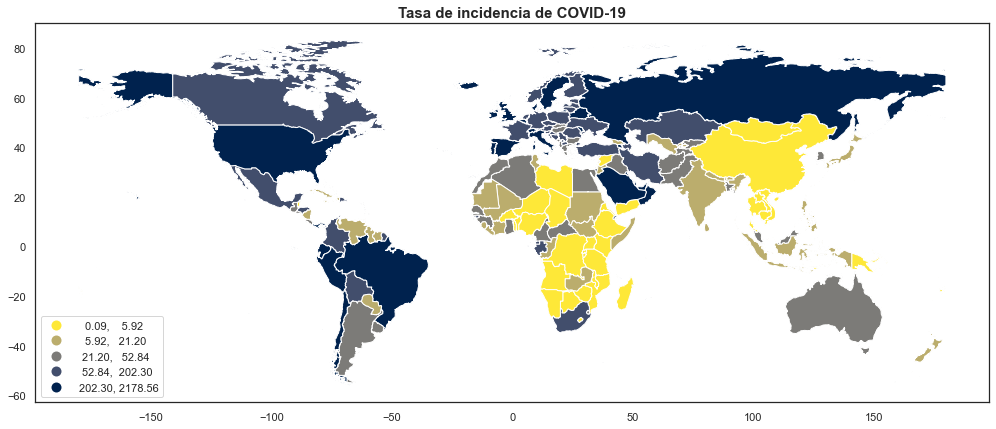

In [310]:
map_plot(ds_map,"Incident_Rate","quantiles","Tasa de incidencia de COVID-19")

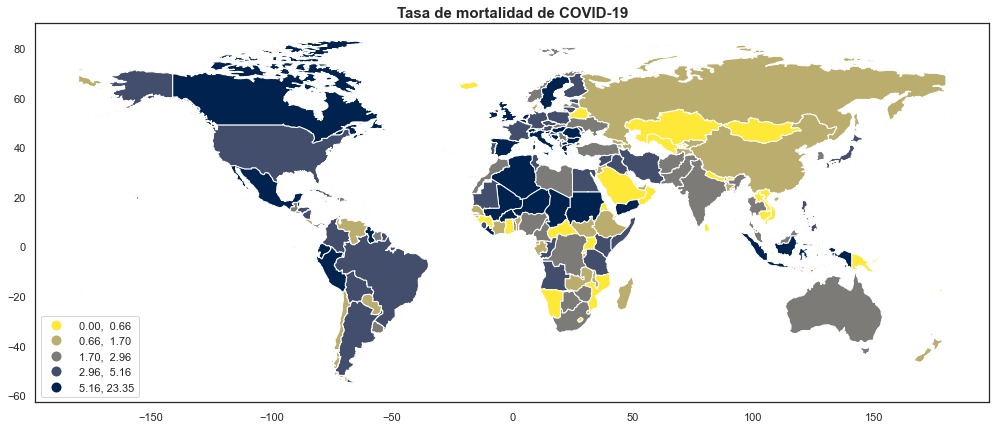

In [311]:
map_plot(ds_map,"Case_Fatality_Ratio","quantiles","Tasa de mortalidad de COVID-19")

Se grafica la distribución de los atributos de entrada numéricos.
>De la gráfica se puede deducir que: 
>- Los atributos ***cases*** y ***deaths*** no tienen una distribución normal, más bien tienen una alta concentración en valores relativamente bajos respecto a su rango global, lo que tiene relación con los países con alta población que presentan en valores absolutos más casos y muertes.
>- 

[]

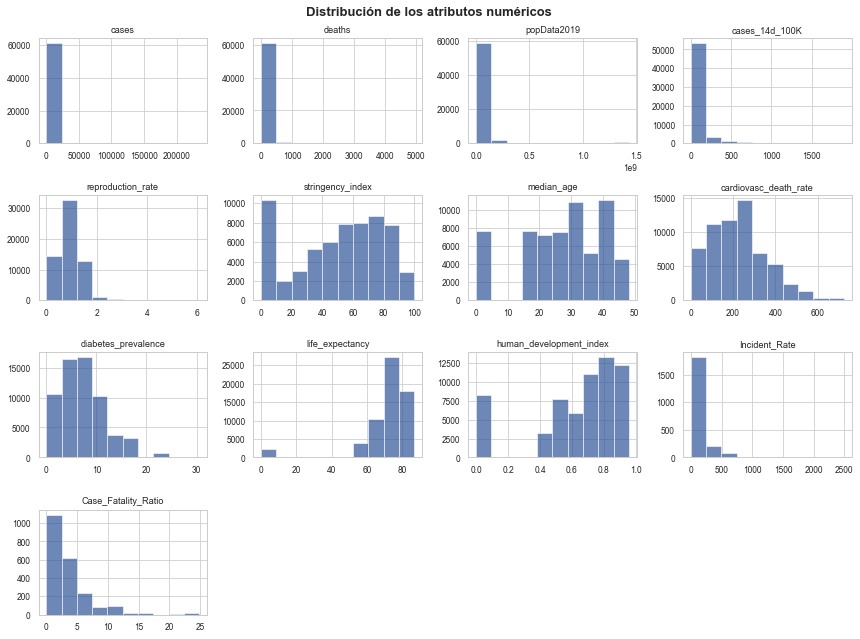

In [312]:
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper",font_scale=0.95, rc={"lines.linewidth": 1.5})
ds.hist(figsize=(12, 9), column=ds.columns[1:],color=color[0],alpha=.7)
plt.suptitle("Distribución de los atributos numéricos",fontweight ="bold", fontsize="13")
plt.subplots_adjust(top=1)
plt.tight_layout()
plt.plot()

Se realiza el diagrama de correlación para conocer de modo general el comportamiento por pares de los atributos.
>Los atributos ***cases*** y ***deaths*** están directamente relacionados. No se observan relaciones directas fuertes de los demás atributos con estas dos variables que son las determinantes en el impacto de la pandemia.


[]

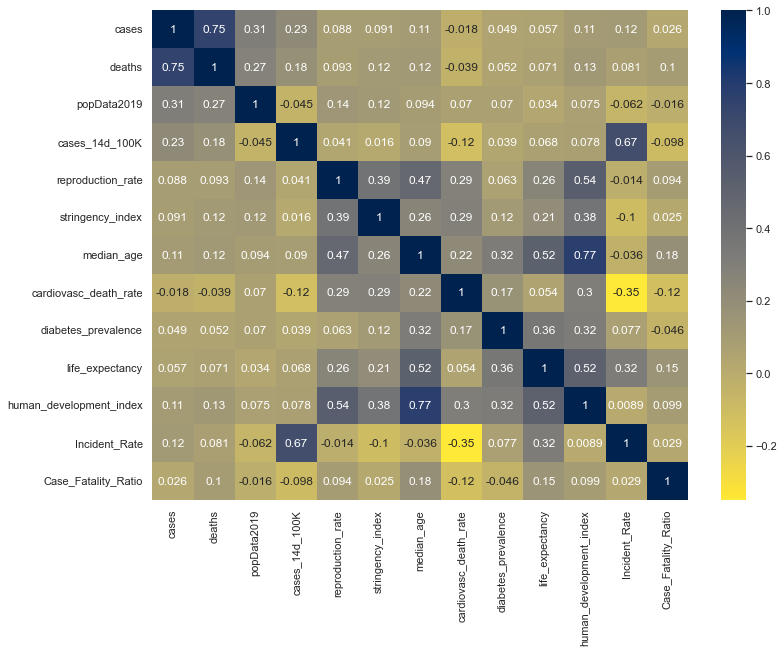

In [313]:
sns.set(rc={'figure.figsize':(12,9)})
sns.heatmap(ds.corr(),annot=True,cmap=cmap)
plt.plot()

## Análisis de impacto a través de algoritmos de clustering
Se aplica algoritmos de clustering para dividir los datos en grupos y determinar el impacto en base a los atributos que se posee. Se definen **cinco grupos** para considerar diferentes niveles de impacto, similar a la escala obtenida en el Análisis Exploratorio de Datos (EDA) para las tasas de incidencia y mortalidad. Se pretendería definir un impacto por grados en base a las muertes (en primer lugar) y el número de casos.. Sin embargo, se analizará los resultados arrojados por los algoritmos.

In [591]:
n_clusters=5

In [628]:
# Función para reordenar los clústers en base a la media de muertes y casos de cada uno
def Reorder_Clusters(ds,cases_col,deaths_col,algorimth):
    ds_clusters=ds.groupby(algorimth).agg(cases_mean=(cases_col,"mean"),deaths_mean=(deaths_col,"mean"),
                       count=(code,pd.Series.nunique)).sort_values(["cases_mean","deaths_mean"],ascending = [False, False])
    clusters_order=ds_clusters.index.values
    ds[algorimth].replace(clusters_order,[4,3,2,1,0],inplace=True)

### Dataset con campos acumulados
Se realiza la agrupación en primer lugar usando campos acumulados (***cases***, ***deaths***, ***popData2019***) y directamente relacionados con la pandemia.

In [719]:
ds_train=ds_evolution[["dateRep",code,"cases","deaths"]]
ds_train=pd.merge(ds_train,ds[["dateRep",code,"popData2019"]],on=["dateRep",code],how='inner',indicator=False).drop("dateRep",axis=1)#.dropna()

Usando **LabelEncoder**  se transforma la columna que contiene el código del país a numérica, ya que los algoritmos no trabajan con valores categóricos.

In [720]:
le = LabelEncoder()
ds_train[code] = le.fit_transform(ds_train[code])

In [721]:
X = ds_train.values 

Se realiza una transformación inversa de LabelEncoder para obtener los códigos de los países.

In [722]:
ds_train[code] = le.inverse_transform(ds_train[code])

In [723]:
ds_train.head()

,countryterritoryCode,cases,deaths,popData2019
0,ABW,5,0,106310.0
1,ABW,5,0,106310.0
2,ABW,5,0,106310.0
3,ABW,5,0,106310.0
4,ABW,6,0,106310.0


Al ser una variable nominal, también se transforma el código del país a númerica, usando **OneHotEncoder** que es la mejor opción para este tipo de variables. Se crea un nuevo array ***X_OneHot*** para las pruebas con esta transformación.

In [724]:
enc = OneHotEncoder()

enc_key = pd.DataFrame(enc.fit_transform(ds_train[[code]]).toarray())
ds_code = ds_train.join(enc_key).drop(code,axis=1)

In [725]:
X_OneHot=ds_code.values

#### Algoritmo KPrototypes
El algoritmo **KPrototypes** usa un esquema similar al algoritmo KMeans de sklearn, pero permite el uso datos combinados: númericos y categóricos<a name="ref-9"/>[(PyPi, 2022)](#cite-KP). Debido a la información que se posee del código de país se usa en primer lugar este algoritmo para agrupar el impacto de COVID-19 y comparar su desempeño con los algoritmos de clustering de **Sklearn**.
>Durante el entrenamiento se observa que este algoritmo tiene un alto costo computacional, pero posee resultados robustos con pocos hiperparámetros.

In [726]:
kproto = KPrototypes(n_clusters=n_clusters) #se selecciona el número de clústers
clusters = kproto.fit_predict(ds_train, categorical=[0]) #en el método fit se seleccionan los campos categóricos
# Se crea el dataframe con los resultados
labels = pd.DataFrame(clusters)
ds_accum = pd.concat((ds_train,labels),axis=1)
ds_accum = ds_accum.rename({0:"c_KPrototype"},axis=1)

In [727]:
ds_accum.head()

,countryterritoryCode,cases,deaths,popData2019,c_KPrototype
0,ABW,5,0,106310.0,4
1,ABW,5,0,106310.0,4
2,ABW,5,0,106310.0,4
3,ABW,5,0,106310.0,4
4,ABW,6,0,106310.0,4


In [728]:
Reorder_Clusters(ds_accum,"cases","deaths","c_KPrototype")

In [729]:
ds_map=ds_accum.groupby([code,"c_KPrototype"]).size().reset_index()
ds_map.drop(ds_map[ds_map[0] == 0 ].index,inplace=True)
ds_map.drop(0,inplace=True,axis=1)

In [730]:
ds_map=ds_map.groupby([code,"c_KPrototype"]).size().reset_index()
ds_map=create_ds_map(ds_map)

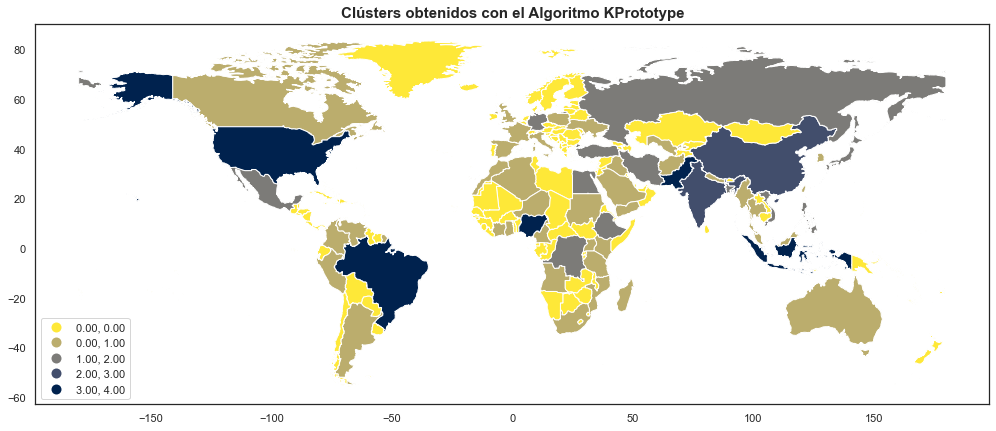

In [731]:
map_plot(ds_map,"c_KPrototype","natural_breaks","Clústers obtenidos con el Algoritmo KPrototype")

#### Algoritmo KMeans
Se usa el algoritmo **KMeans** para crear los cinco clústers planteados. Este algoritmo crea clústers circulares basados en la distancia a los centroides..<a name="ref-10"/>[(Scikitlearn, 2022)](#cite-SKL-KM)

In [732]:
# definimos y ajustamos el modelo
model = KMeans(n_clusters=n_clusters)
model.fit(X)
# se predice el clúster para cada elemento del array de entrada
yhat = model.predict(X)

In [733]:
ds_accum["c_KMeans"]=yhat

In [734]:
Reorder_Clusters(ds_accum,"cases","deaths","c_KMeans")

In [735]:
ds_map=ds_accum.groupby([code,"c_KMeans"]).size().reset_index()
ds_map.drop(ds_map[ds_map[0] == 0 ].index,inplace=True)
ds_map.drop(0,inplace=True,axis=1)

In [736]:
ds_map=ds_map.groupby([code,"c_KMeans"]).size().reset_index()
ds_map=create_ds_map(ds_map)

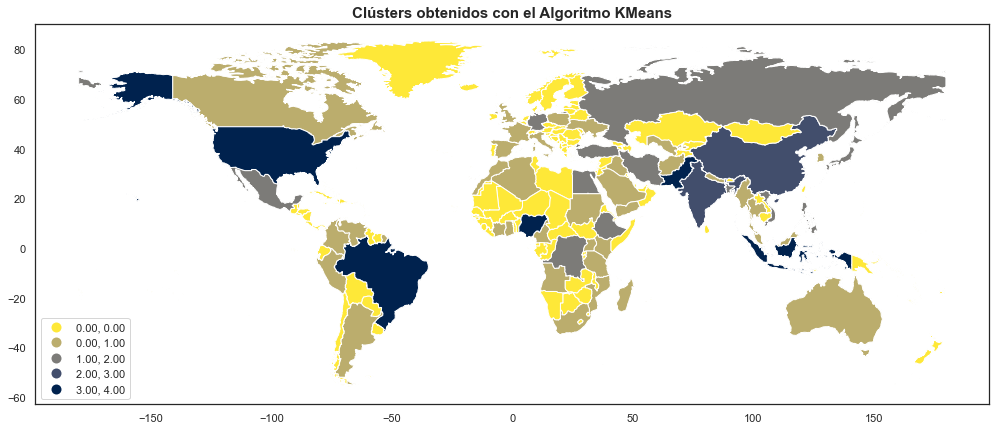

In [737]:
map_plot(ds_map,"c_KMeans","natural_breaks","Clústers obtenidos con el Algoritmo KMeans")

#### Algoritmo KMeans con OneHotEncoder
Se aplica el mismo algoritmo anterior, pero usando el dataset transformado con OneHotEncoder para la conversión de los países.

In [738]:
# definimos y ajustamos el modelo
model = KMeans(n_clusters=n_clusters)
model.fit(X_OneHot)
# se predice el clúster para cada elemento del array de entrada
yhat = model.predict(X_OneHot)

In [739]:
ds_accum["c_wOneHot"]=yhat

In [740]:
Reorder_Clusters(ds_accum,"cases","deaths","c_wOneHot")

In [741]:
ds_map=ds_accum.groupby([code,"c_wOneHot"]).size().reset_index()
ds_map.drop(ds_map[ds_map[0] == 0 ].index,inplace=True)
ds_map.drop(0,inplace=True,axis=1)

In [742]:
ds_map=ds_map.groupby([code,"c_wOneHot"]).size().reset_index()
ds_map=create_ds_map(ds_map)

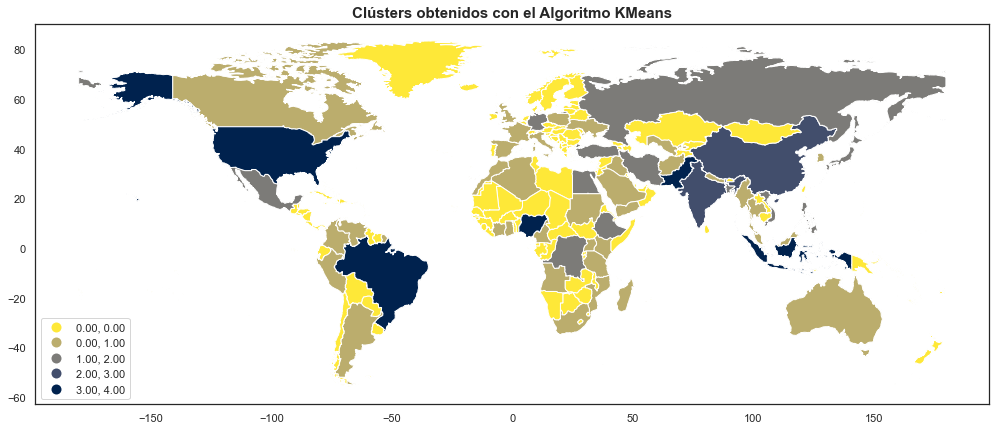

In [743]:
map_plot(ds_map,"c_wOneHot","natural_breaks","Clústers obtenidos con el Algoritmo KMeans")

#### Algoritmo Gaussian Mixture
Se prueba también el algoritmo **Gaussian Mixture** <a name="ref-11"/>[(Scikitlearn, 2022)](#cite-SKL-GM), A diferencia de KMeans que crea solamente grupos circulares basados en la distancia, este algoritmo toma en cuenta la varianza y crea agrupaciones de forma variada.

In [744]:
# definimos y ajustamos el modelo
model = GaussianMixture(n_components=n_clusters)
model.fit(X)
# predecimos los clúster
yhat = model.predict(X)

In [745]:
ds_accum["c_GMixture"]=yhat

In [746]:
Reorder_Clusters(ds_accum,"cases","deaths","c_GMixture")

Este algoritmo posee más filas que número de países, lo que implica que varios países están asignados a más de un clúster. Para la gráfica se toma el grupo con más instancias asignadas.

In [747]:
ds_map=ds_accum.groupby([code,"c_GMixture"]).size().reset_index()

In [748]:
ds_map.shape

(372, 3)

In [749]:
ds_map=ds_map.groupby(code).max()
ds_map=create_ds_map(ds_map)

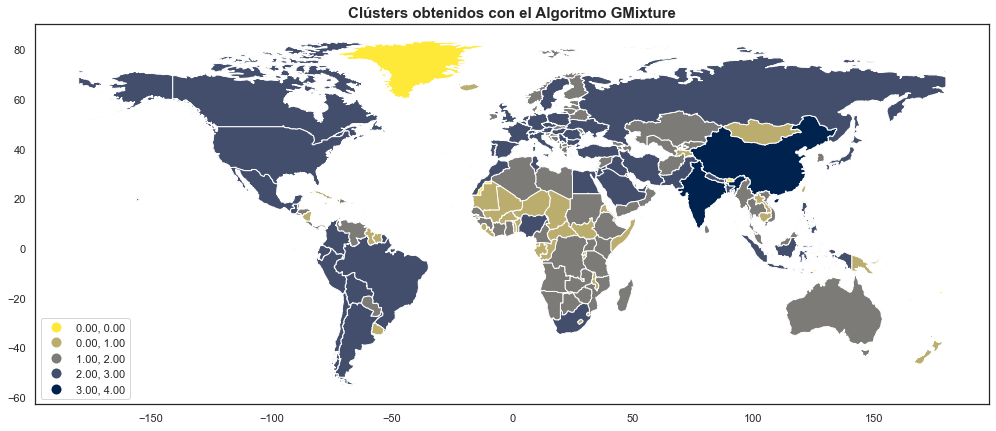

In [750]:
map_plot(ds_map,"c_GMixture","natural_breaks","Clústers obtenidos con el Algoritmo GMixture")

#### Comparación de los algoritmos
Se realiza un análisis comparativo de los cuatro algoritmos.
>Los algoritmos basados en distancias presentan la misma distribución.

In [751]:
np.set_printoptions(suppress=True)

In [752]:
ds_accum.head()

,countryterritoryCode,cases,deaths,popData2019,c_KPrototype,c_KMeans,c_wOneHot,c_GMixture
0,ABW,5,0,106310.0,0,0,0,0
1,ABW,5,0,106310.0,0,0,0,0
2,ABW,5,0,106310.0,0,0,0,0
3,ABW,5,0,106310.0,0,0,0,0
4,ABW,6,0,106310.0,0,0,0,0


Para cada algoritmo entrenado se realiza una validación de los grupos para conocer las características de cada uno. En todos los casos la media de los casos tiene relación directamente proporcional con el número de muertes.

In [753]:
for algorimth in ["c_KPrototype","c_KMeans","c_wOneHot","c_GMixture"]:
    ds_cluster=ds_accum.groupby(algorimth).agg(cases_mean=("cases","mean"),deaths_mean=("deaths","mean"),
                                              count=(code,pd.Series.nunique)).sort_values(["cases_mean","deaths_mean"],ascending = [False, False])
    print("\033[1m{:}\033[0m".format(algorimth))
    print(ds_cluster)

c_KPrototype
                cases_mean   deaths_mean  count
c_KPrototype                                   
4             1.797981e+06  44549.029531      5
3             1.785380e+06  28388.608011      2
2             2.813755e+05   9602.989723     12
1             1.776346e+05   5965.653894     37
0             2.788214e+04    601.883876    156
c_KMeans
            cases_mean   deaths_mean  count
c_KMeans                                   
4         1.797981e+06  44549.029531      5
3         1.785380e+06  28388.608011      2
2         2.813755e+05   9602.989723     12
1         1.880148e+05   6314.077054     35
0         2.750749e+04    593.955687    158
c_wOneHot
             cases_mean   deaths_mean  count
c_wOneHot                                   
4          1.797981e+06  44549.029531      5
3          1.785380e+06  28388.608011      2
2          2.813755e+05   9602.989723     12
1          1.880148e+05   6314.077054     35
0          2.750749e+04    593.955687    158
c_GMixtur

Se realiza una gráfica comparativa de la distribución de cada algoritmo
>El algoritmo **KMeans** - con y sin OneHotEncoder - presenta la misma distribución en los clústers. El algoritmo **KPrototype** tiene una ligera diferencia en dos grupos.

>El algoritmo **GMixture** por otra parte, agrupa los países de diferentes categorías, generando su participación en dos grupos. En la gráfica de coropletas se consideró el clúster con más frecuencia. Sin embargo, se entiende que al emplear los algoritmos tradicionales,no se toma en cuenta la temporalidad y el código de país interviene como un atributo adicional que no tiene por qué ser considerado dentro de un mismo clúster. El que un país pertenezca a más de un clúster puede implicar cambios en la situación de dicho país según la evolución de la pandemia.

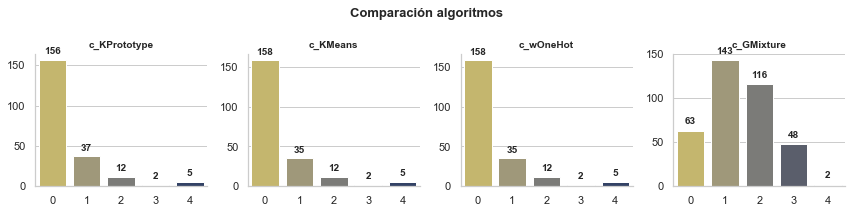

In [755]:
sns.set(rc={'figure.figsize':(12,3)})
sns.set_style("whitegrid")
fig,axes = plt.subplots(1,4)
fig.suptitle('Comparación algoritmos',fontweight ="bold", fontsize="13")

i=0
for algorimth in ["c_KPrototype","c_KMeans","c_wOneHot","c_GMixture"]:
    ax=sns.countplot(data=ds_accum.groupby([code,algorimth]).size().reset_index(),x=algorimth,palette=cmap,ax=axes[i])
    axes[i].set_title(algorimth,fontweight ="bold",fontsize="10")
    axes[i].set(xlabel=None,ylabel=None)
    for p in ax.patches:
       ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()+7.5), ha='center', size=10, weight='bold')
    i+=1

plt.subplots_adjust(top=1)
plt.tight_layout()
sns.despine()
plt.show()
    

### Dataset con tasas de incidencia
Se prepara un nuevo dataset, usando en este caso la incidencia y el índice de mortalidad, parámetros que ya están relacionados con la población. El dataset inicial posee ya este cálculo importado del dataset de CSSE, pero tiene un número reducido de países por lo que se analiza la factibilidad de calcular dichos atributos y no disminuir drásticamente el número de países de estudio:
- ***Incidencia acumulada:*** _se calcula dividiendo el número de casos aparecidos en un periodo entre el número de personas que están libres de la enfermedad al inicio del período_ <a name="ref-12"/>[(Sanitaria, 2022)](#cite-CV19-IncidentRate). Este campo ya se encuentra en el dataset y correspondería a ***cases_14d_100K***.
- ***Índice de mortalidad (IFR):*** _La verdadera gravedad de una enfermedad puede definirse por la razón de letalidad de la infección_<a name="ref-13"/>[(OMS, 2020)](#cite-CV19-FatalitytRate). Puede calcularse con los datos presentes:

$$IFR=\frac{Muertes\_por\_la\_enfermedad}{Personas\_infectadas}$$

In [704]:
ds_rates=ds[[code,"cases_14d_100K"]]
ds_rates["IFR"]=ds["deaths"]/ds["cases"]

In [705]:
# Se reemplaza los valores infinitos por NAN y se eliminan.
ds_rates.replace([np.inf, -np.inf], np.nan, inplace=True)
ds_rates.dropna(inplace=True)

In [706]:
ds_rates.head()

,countryterritoryCode,cases_14d_100K,IFR
0,AFG,9.013779,0.008043
1,AFG,7.052776,0.030201
2,AFG,6.868768,0.097345
3,AFG,7.134266,0.158730
4,AFG,6.968658,0.079208


In [707]:
ds_rates.isna().sum()

countryterritoryCode    0
cases_14d_100K          0
IFR                     0
dtype: int64

Usando **LabelEncoder** se convierte a númerico el código de país. Se usa este criterio ya que se observaron los mismos resultados que usando _OneHotEncoder_

In [708]:
le = LabelEncoder()
ds_rates[code] = le.fit_transform(ds_rates[code])

In [709]:
X = ds_rates.values 

In [710]:
ds_rates[code] = le.inverse_transform(ds_rates[code])

#### Algoritmo KMeans

In [711]:
# definimos y ajustamos el modelo
model = KMeans(n_clusters=n_clusters,random_state=0)
model.fit(X)
# se predice el clúster para cada elemento del array de entrada
yhat = model.predict(X)

In [712]:
ds_rates["c_KMeans"]=yhat

In [713]:
Reorder_Clusters(ds_rates,"cases_14d_100K","IFR","c_KMeans")

In [714]:
ds_map=create_ds_map(ds_rates)

En el análisis se puede observar que existe más de un grupo asignado a cada país por lo que se toma el con más instancias en cada caso.

In [715]:
algorimth="c_KMeans"
ds_cluster=ds_rates.groupby(algorimth).agg(cases_mean=("cases_14d_100K","mean"),deaths_mean=("IFR","mean"),
                                           count=(code,pd.Series.nunique)).sort_values(["cases_mean","deaths_mean"],ascending = [False, False])
print("\033[1m{:}\033[0m".format(algorimth))
ds_cluster

c_KMeans


,cases_mean,deaths_mean,count
c_KMeans,,,
4,1160.173966,0.014936,23
3,583.085382,0.018306,61
2,226.595958,0.025846,106
1,25.585660,0.037744,109
0,24.531054,0.031965,101


In [716]:
ds_map=ds_map.groupby(code).max()
ds_map=create_ds_map(ds_map)
ds_map.shape

(211, 4)

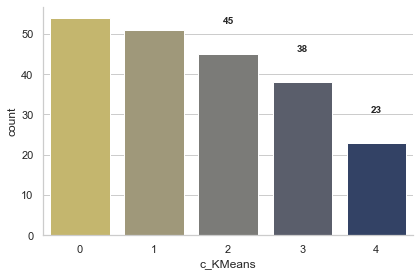

In [717]:
sns.set(rc={'figure.figsize':(6,4)})
sns.set_style("whitegrid")
ax=sns.countplot(data=ds_map,x="c_KMeans",palette=cmap)
for p in ax.patches:
   ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()+7.5), ha='center', size=10, weight='bold')
plt.tight_layout()
sns.despine()
plt.show()

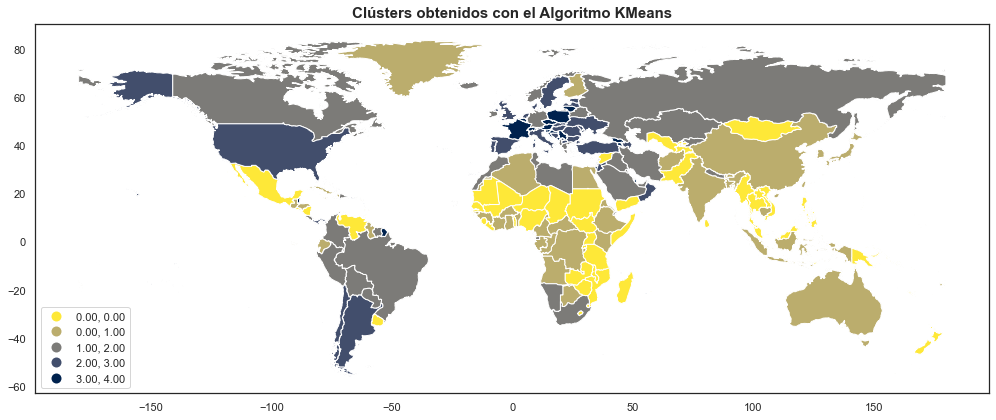

In [718]:
map_plot(ds_map,"c_KMeans","natural_breaks","Clústers obtenidos con el Algoritmo KMeans")

### Dataset Agrupado
Tomando en cuenta que en los dos puntos anteriores no se ha considerado la evolución temporal y se ha descartado la fecha, lo cual puede tener un impacto en la agrupación, para usar los métodos de clustering convencionales se crea un dataset que elimina la temporalidad y contiene los valores resumen de los campos ***cases***, ***deaths*** y ***popData2019***.

In [622]:
ds_group=ds_train.groupby(code).agg(cases=('cases','sum'), 
                         deaths=('deaths','sum'), 
                         popData2019=('popData2019','mean')).reset_index()

In [600]:
ds_group.head()

,countryterritoryCode,cases,deaths,popData2019
0,ABW,532171,5112,106310.0
1,AFG,7843873,288858,38041757.0
2,AGO,1482574,36783,31825299.0
3,AIA,1809,0,14872.0
4,ALB,4634190,108352,2862427.0


Al ser una variable nominal, también se transforma el código del país a númerica, usando **OneHotEncoder** que es la mejor opción para este tipo de variables. Se crea un nuevo array ***X_OneHot*** para las pruebas con esta transformación.

In [527]:
enc = OneHotEncoder()

enc_key = pd.DataFrame(enc.fit_transform(ds_group[[code]]).toarray())
ds_code = ds_group.join(enc_key).drop(code,axis=1)

In [528]:
X=ds_code.values

#### Algoritmo K-Means

In [623]:
# definimos y ajustamos el modelo
model = KMeans(n_clusters=n_clusters)
model.fit(X)
# se predice el clúster para cada elemento del array de entrada
yhat = model.predict(X)

In [624]:
ds_group["c_KMeans"]=yhat

In [625]:
Reorder_Clusters(ds_group,"cases","deaths","c_KMeans")

In [605]:
ds_map=ds_group.groupby([code,"c_KMeans"]).size().reset_index()
ds_map=create_ds_map(ds_map)

Este algoritmo considera un mayor número de países en un grupo que tiene como media el menor número de casos y de muertes.

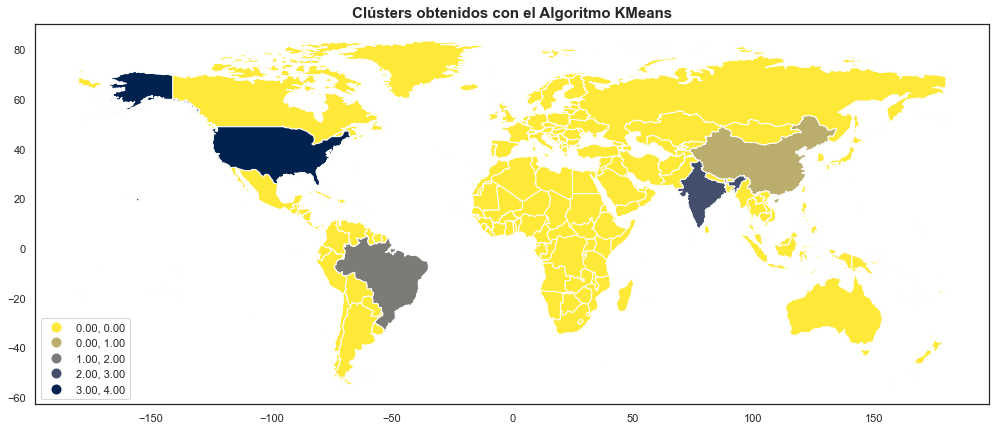

In [606]:
map_plot(ds_map,"c_KMeans","natural_breaks","Clústers obtenidos con el Algoritmo KMeans")

#### Algoritmo Gaussian Mixture
Se prueba también el algoritmo Gaussian Mixture [](#cite), obteniendo los mismos resultados que con el algoritmo KMeans.

In [629]:
# definimos y ajustamos el modelo
model = GaussianMixture(n_components=n_clusters, reg_covar=1e-02)
model.fit(X)
# predecimos los clúster
yhat = model.predict(X)

In [630]:
ds_group["c_GMixture"]=yhat

In [631]:
Reorder_Clusters(ds_group,"cases","deaths","c_GMixture")

In [632]:
ds_map=create_ds_map(ds_group)

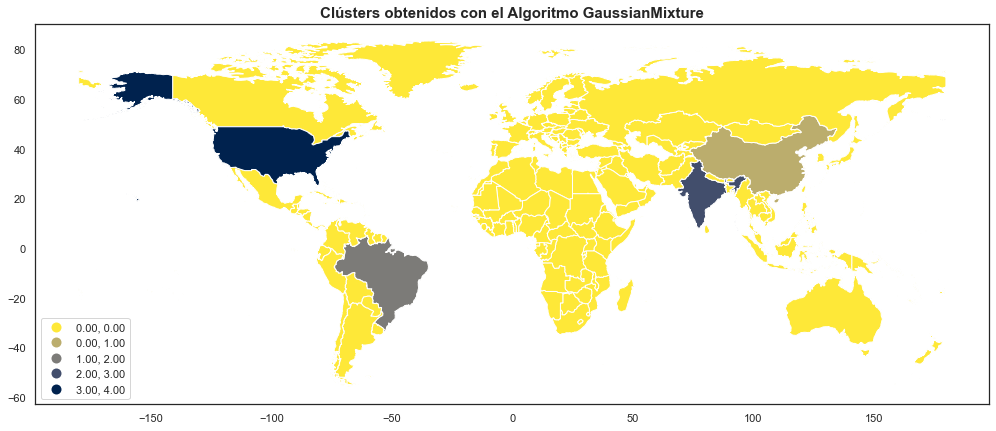

In [633]:
map_plot(ds_map,"c_GMixture","natural_breaks","Clústers obtenidos con el Algoritmo GaussianMixture")

#### Algoritmo Fuzzy cmeans
_Los principios de la lógica difusa se pueden utilizar para agrupar datos multidimensionales, asignando a cada punto una pertenencia en cada centro de agrupación del 0 al 100 por ciento_ <a name="ref-14"/>[(SciKit-Fuzzy, 2022)](#cite-PH-FCM).

In [635]:
fcm = FCM(n_clusters=n_clusters)
fcm.fit(np.array(X))
fcm_centers = fcm.centers
fcm_labels = fcm.predict(np.array(X))

In [636]:
ds_group["c_FCM"]=fcm_labels

In [637]:
Reorder_Clusters(ds_group,"cases","deaths","c_FCM")

In [638]:
ds_map=create_ds_map(ds_group)

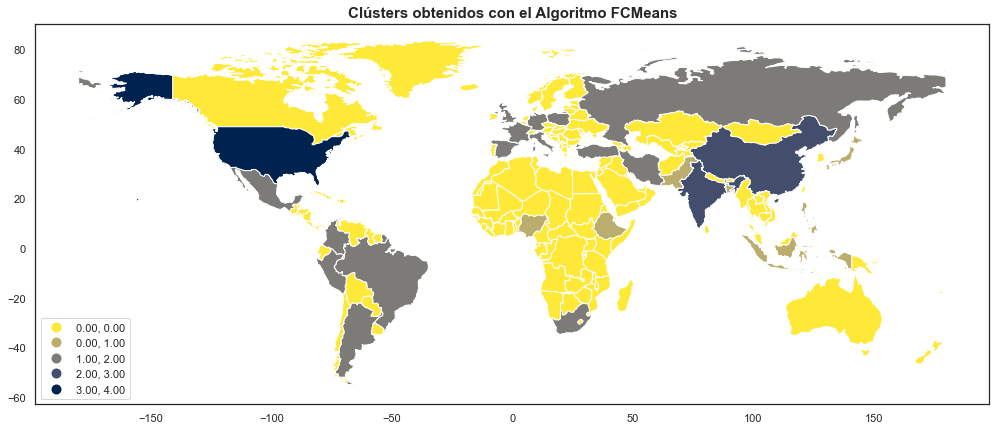

In [639]:
map_plot(ds_map,"c_FCM","natural_breaks","Clústers obtenidos con el Algoritmo FCMeans")

#### Comparación de los algoritmos
Se realiza un análisis comparativo de los tres algoritmos. En general se observa que al trabajar con valores resumen la agrupación es mucho más generalista y disminuyen datos de los puntos intermedios.
>El algoritmo **fcmeans** es el que logra mejor discriminación entre los grupos.

In [640]:
ds_group.head()

,countryterritoryCode,cases,deaths,popData2019,c_KMeans,c_GMixture,c_FCM
0,ABW,532171,5112,106310.0,0,0,0
1,AFG,7843873,288858,38041757.0,0,0,0
2,AGO,1482574,36783,31825299.0,0,0,0
3,AIA,1809,1,14872.0,0,0,0
4,ALB,4634190,108352,2862427.0,0,0,0


Para cada algoritmo entrenado se realiza una validación de los grupos para conocer las características de cada uno.

In [641]:
for algorimth in ["c_KMeans","c_GMixture","c_FCM"]:
    ds_cluster=ds_group.reset_index().groupby(algorimth).agg(cases_mean=("cases","mean"),deaths_mean=("deaths","mean"),
                                              count=(code,pd.Series.nunique)).sort_values(["deaths_mean","cases_mean"],ascending = [False, False])
    print("\033[1m{:}\033[0m".format(algorimth))
    print(ds_cluster)

c_KMeans
            cases_mean   deaths_mean  count
c_KMeans                                   
4         2.006647e+09  4.604032e+07      1
2         9.512078e+08  2.698939e+07      1
3         1.225652e+09  1.867716e+07      1
1         2.232910e+07  1.166482e+06      1
0         2.144914e+07  6.469928e+05    208
c_GMixture
              cases_mean   deaths_mean  count
c_GMixture                                   
4           2.006647e+09  4.604032e+07      1
2           9.512078e+08  2.698939e+07      1
3           1.225652e+09  1.867716e+07      1
1           2.232910e+07  1.166482e+06      1
0           2.144914e+07  6.469928e+05    208
c_FCM
         cases_mean   deaths_mean  count
c_FCM                                   
4      2.006647e+09  4.604032e+07      1
3      6.239904e+08  9.921818e+06      2
2      2.277791e+08  7.882326e+06     15
1      4.322005e+07  9.238829e+05      7
0      9.055624e+06  1.971221e+05    187


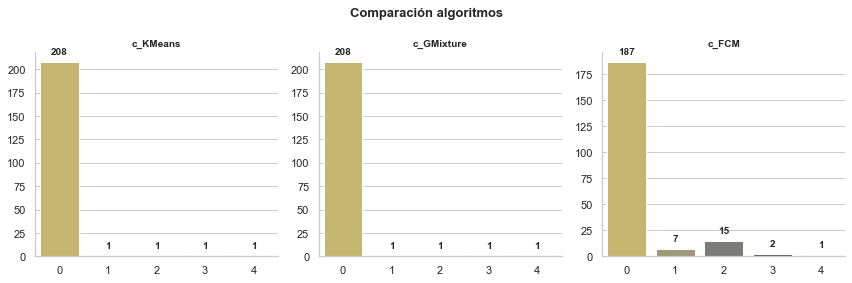

In [642]:
sns.set(rc={'figure.figsize':(12,4)})
sns.set_style("whitegrid")
fig,axes = plt.subplots(1,3)
fig.suptitle('Comparación algoritmos',fontweight ="bold", fontsize="13")

i=0
for algorimth in ["c_KMeans","c_GMixture","c_FCM"]:
    ax=sns.countplot(data=ds_map,x=algorimth,palette=cmap,ax=axes[i])
    axes[i].set_title(algorimth,fontweight ="bold",fontsize="10")
    axes[i].set(xlabel=None,ylabel=None)
    for p in ax.patches:
       ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()+7.5), ha='center', size=10, weight='bold')
    i+=1

plt.subplots_adjust(top=1)
plt.tight_layout()
sns.despine()
plt.show()
    

### Timeseries Dataset
Los análisis de los pasos previos no han considerado la temporalidad, en este apartado se realiza el análisis usando **tslearn** que  _es un paquete de Python que proporciona herramientas de aprendizaje automático para el análisis de series temporales_ <a name="ref-15"/>[(tsLearn, 2022)](#cite-TSL). 
> Se extrae inicialmente para el análisis Los campos ***casos*** y ***muertes*** y se transforma el dataset en uno adaptado a series temporales.

In [467]:
def Normalize_Series(mySeries):
    for i in range(len(mySeries)):
        scaler = MinMaxScaler()
        mySeries[i] = MinMaxScaler().fit_transform(mySeries[i])

In [643]:
ds_time=ds[["dateRep",code,"cases","deaths","popData2019"]].sort_values([code,"dateRep"],ascending = [True, True])
ds_time["dateRep"]=ds_time["dateRep"].astype("string")

Se crea el array de las series temporales para cada uno de los países (un total de 212 series). <a name="ref-16"/>[(Kaggle, 2021)](#cite-KGL-TS)
>Al analizar las series se observa que no tienen el mismo tamaño,por lo que es necesario lograr uniformidad antes de entrenar los algoritmos.

In [644]:
mySeries = []
countries_list=ds_time[code].unique()
for country in countries_list:
    df=ds_time.loc[ds_train[code] == country][["dateRep","cases","deaths"]]
    df.set_index("dateRep",inplace=True)
    df.sort_index(inplace=True)
    mySeries.append(df)

In [645]:
len(mySeries)

212

In [646]:
series_lengths = [len(series) for series in mySeries]
print(series_lengths)

[267, 340, 268, 263, 281, 276, 344, 283, 341, 270, 350, 350, 343, 258, 350, 273, 257, 277, 275, 280, 349, 272, 277, 342, 266, 270, 277, 350, 272, 279, 276, 258, 274, 350, 350, 285, 350, 276, 277, 350, 277, 274, 279, 227, 269, 282, 275, 266, 270, 278, 350, 350, 271, 267, 350, 341, 345, 345, 346, 268, 233, 349, 345, 276, 346, 270, 255, 350, 284, 276, 350, 347, 270, 276, 270, 275, 272, 263, 275, 348, 267, 270, 275, 271, 275, 276, 347, 270, 284, 343, 269, 349, 348, 350, 348, 350, 347, 350, 277, 270, 277, 350, 275, 276, 271, 341, 264, 350, 347, 265, 346, 273, 265, 275, 279, 341, 214, 341, 343, 283, 280, 338, 280, 269, 280, 350, 47, 341, 264, 283, 267, 272, 274, 259, 267, 275, 268, 270, 256, 349, 275, 269, 269, 339, 271, 350, 350, 337, 341, 344, 345, 280, 282, 346, 269, 284, 262, 287, 278, 281, 271, 346, 348, 350, 275, 284, 276, 280, 350, 60, 258, 271, 349, 273, 280, 253, 250, 270, 282, 284, 350, 275, 264, 275, 267, 265, 270, 276, 343, 228, 268, 277, 281, 276, 273, 268, 276, 275, 350, 274, 2

>Se crea una lista de todas las series (países) que no poseen datos completos, ya que los valores representan nuevos casos y nuevas muertes, se rellena las fechas vacías con ceros.

In [647]:
longest_serie=mySeries[series_lengths.index(max(series_lengths))]
problem_indexes=[i for i in range(len(series_lengths)) if series_lengths[i] != max(series_lengths)]

In [648]:
for i in problem_indexes:
    for date in longest_serie.index:
        try:
            mySeries[i].loc[date]
        except:
            mySeries[i].loc[date]=[0,0]

Se normaliza cada una de las series en su propio rango.

In [649]:
Normalize_Series(mySeries)

Se transforma el array al tipo timeseries que se requiere para el entrenamiento de los algoritmos <a name="ref-17"/>[(tslearn, 2022)](#cite-TTSDUtil). Este es un array de tres dimensiones, en los que una de ellas corresponde a las diferentes series.

In [650]:
mySeries=to_time_series_dataset(mySeries)

#### Algoritmo Time Series KMeans

In [651]:
# definimos y ajustamos el modelo
model = tsKMeans(n_clusters=n_clusters,random_state=42,metric="dtw") # la métrica dtw es la que mejores resultados brinda con la temporalidad
model.fit(mySeries)
# se predice el clúster para cada elemento del array de entrada
yhat = model.predict(mySeries)

In [652]:
ds_group["c_tsKMeans"]=yhat

In [653]:
Reorder_Clusters(ds_group,"cases","deaths","c_tsKMeans")

In [654]:
ds_map=create_ds_map(ds_group)

Se analiza el modelo propuesto por este algoritmo. Se puede notar una mejor discriminación y distribución. Se usa el dataset agrupado para el cálculo de las medias.

In [655]:
algorimth="c_tsKMeans"
ds_cluster=ds_group.reset_index().groupby(algorimth).agg(cases_mean=("cases","mean"),deaths_mean=("deaths","mean"),
                                           count=(code,pd.Series.nunique)).sort_values(["cases_mean","deaths_mean"],ascending = [False, False])
print("\033[1m{:}\033[0m".format(algorimth))
ds_cluster

c_tsKMeans
              cases_mean   deaths_mean  count
c_tsKMeans                                   
4           3.321246e+08  7.238466e+06      7
3           7.412135e+07  1.957166e+06     49
2           5.756728e+07  1.564871e+06     13
1           1.386699e+07  4.829335e+05     89
0           1.347966e+07  3.250567e+05     54


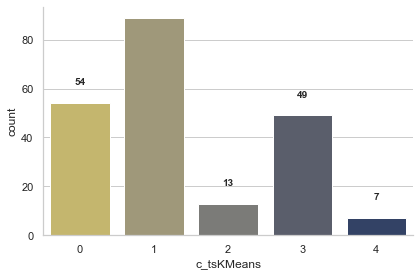

In [656]:
sns.set(rc={'figure.figsize':(6,4)})
sns.set_style("whitegrid")
ax=sns.countplot(data=ds_map,x="c_tsKMeans",palette=cmap)
for p in ax.patches:
   ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()+7.5), ha='center', size=10, weight='bold')
plt.tight_layout()
sns.despine()
plt.show()

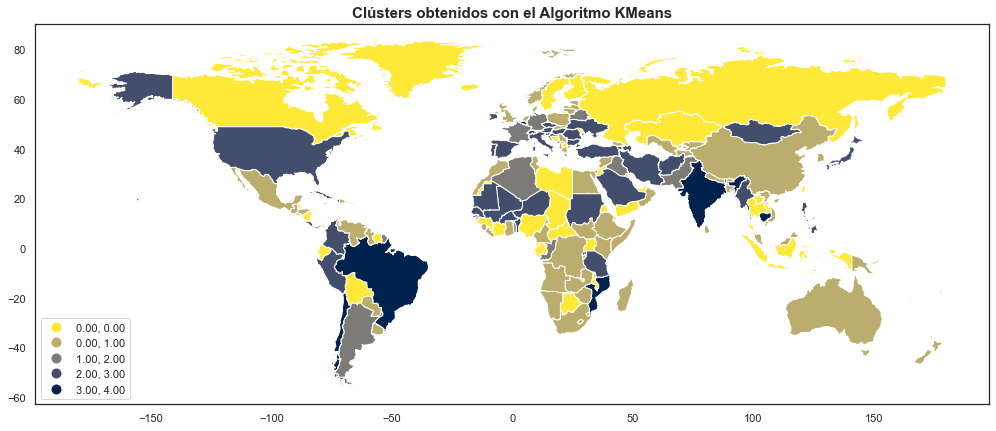

In [657]:
map_plot(ds_map,"c_tsKMeans","natural_breaks","Clústers obtenidos con el Algoritmo KMeans")

### Timeseries Dataset con incidencias
En esta caso se usan las tasas de incidencias en lugar de los valores absolutos.

In [658]:
ds_time_rates=ds[["dateRep",code,"cases_14d_100K"]].sort_values([code,"dateRep"],ascending = [True, True])
ds_time_rates["IFR"]=ds["deaths"]/ds["cases"]
ds_time_rates["dateRep"]=ds_time_rates["dateRep"].astype("string")

Se crea el array de las series temporales para cada uno de los países (un total de 212 series).

In [659]:
mySeries = []
countries_list=ds_time_rates[code].unique()
for country in countries_list:
    df=ds_time_rates.loc[ds_time_rates[code] == country][["dateRep","cases_14d_100K","IFR"]]
    df.set_index("dateRep",inplace=True)
    df.sort_index(inplace=True)
    mySeries.append(df)

In [660]:
len(mySeries)

212

In [661]:
series_lengths = [len(series) for series in mySeries]
print(series_lengths)

[267, 340, 268, 263, 281, 276, 344, 283, 341, 270, 350, 350, 343, 258, 350, 273, 257, 277, 275, 280, 349, 272, 277, 342, 266, 270, 277, 350, 272, 279, 276, 258, 274, 350, 350, 285, 350, 276, 277, 350, 277, 274, 279, 227, 269, 282, 275, 266, 270, 278, 350, 350, 271, 267, 350, 341, 345, 345, 346, 268, 233, 349, 345, 276, 346, 270, 255, 350, 284, 276, 350, 347, 270, 276, 270, 275, 272, 263, 275, 348, 267, 270, 275, 271, 275, 276, 347, 270, 284, 343, 269, 349, 348, 350, 348, 350, 347, 350, 277, 270, 277, 350, 275, 276, 271, 341, 264, 350, 347, 265, 346, 273, 265, 275, 279, 341, 214, 341, 343, 283, 280, 338, 280, 269, 280, 350, 47, 341, 264, 283, 267, 272, 274, 259, 267, 275, 268, 270, 256, 349, 275, 269, 269, 339, 271, 350, 350, 337, 341, 344, 345, 280, 282, 346, 269, 284, 262, 287, 278, 281, 271, 346, 348, 350, 275, 284, 276, 280, 350, 60, 258, 271, 349, 273, 280, 253, 250, 270, 282, 284, 350, 275, 264, 275, 267, 265, 270, 276, 343, 228, 268, 277, 281, 276, 273, 268, 276, 275, 350, 274, 2

Se crea una lista de todas las series (países) que no poseen datos completos, ya que los valores representan nuevos casos y nuevas muertes, se rellena las fechas vacías con ceros.

In [662]:
problem_indexes=[i for i in range(len(series_lengths)) if series_lengths[i] != max(series_lengths)]

In [663]:
for serie in mySeries:
    serie.replace([np.inf, -np.inf], np.nan, inplace=True)

In [664]:
def nan_counter(list_of_series):
    nan_polluted_series_counter = 0
    for series in list_of_series:
        if series.isnull().sum().sum() > 0:
            nan_polluted_series_counter+=1
    print(nan_polluted_series_counter)

In [665]:
nan_counter(mySeries)

212


In [666]:
for i in problem_indexes:
    mySeries[i].interpolate(limit_direction="both",inplace=True)

In [667]:
nan_counter(mySeries)

25


In [668]:
for serie in mySeries:
    serie.dropna(inplace=True)

In [669]:
nan_counter(mySeries)

0


Se normaliza cada una de las series en su propio rango.

In [670]:
Normalize_Series(mySeries)

In [671]:
mySeries=to_time_series_dataset(mySeries)

#### Algoritmo Time Series KMeans

In [672]:
len(mySeries[1])

349

In [673]:
# definimos y ajustamos el modelo
model = tsKMeans(n_clusters=n_clusters,random_state=42,metric="dtw")
model.fit(mySeries)
# se predice el clúster para cada elemento del array de entrada
yhat = model.predict(mySeries)

In [674]:
ds_group["c_tsKMeans_rates"]=yhat

In [675]:
Reorder_Clusters(ds_group,"cases","deaths","c_tsKMeans_rates")

In [676]:
ds_map=create_ds_map(ds_group)

Se analiza el modelo propuesto por este algoritmo. Con los valores de tasas existe una distribución más balanceada que todos los algoritmos analizados hasta el momento.

In [678]:
algorimth="c_tsKMeans_rates"
ds_cluster=ds_group.groupby(algorimth).agg(cases_mean=("cases","mean"),deaths_mean=("deaths","mean"),
                                           count=(code,pd.Series.nunique)).sort_values(["cases_mean","deaths_mean"],ascending = [False, False])
print("\033[1m{:}\033[0m".format(algorimth))
ds_cluster

c_tsKMeans_rates


,cases_mean,deaths_mean,count
c_tsKMeans_rates,,,
4,7.431292e+07,1.981569e+06,65
3,7.384933e+07,1.603146e+06,13
2,7.225484e+07,1.949638e+06,31
1,1.050348e+07,2.731065e+05,54
0,1.424257e+06,5.343763e+04,49


De acuerdo al análisis de agrupamiento este es el algoritmo que mejor discriminación presenta.

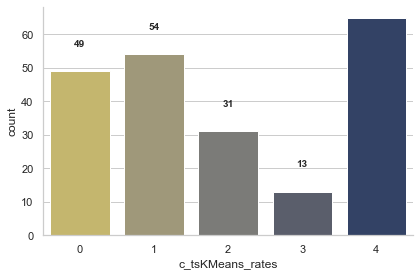

In [679]:
sns.set(rc={'figure.figsize':(6,4)})
sns.set_style("whitegrid")
ax=sns.countplot(data=ds_map,x="c_tsKMeans_rates",palette=cmap)
for p in ax.patches:
   ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()+7.5), ha='center', size=10, weight='bold')
plt.tight_layout()
sns.despine()
plt.show()

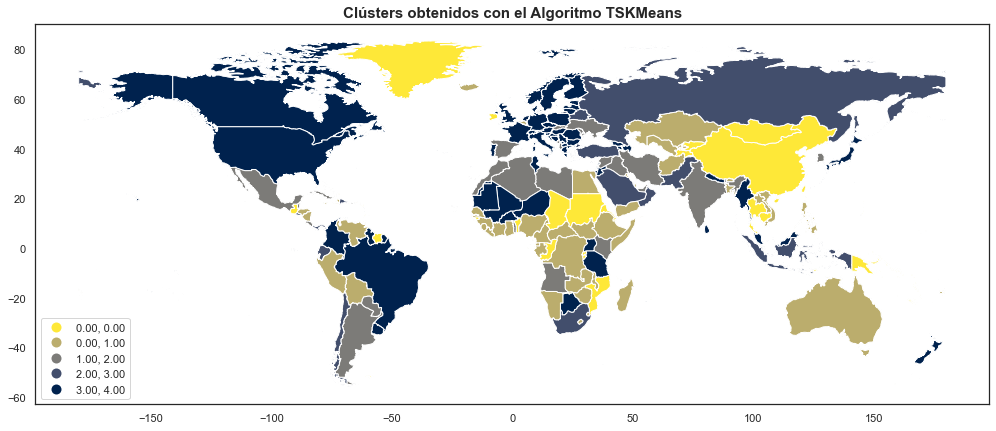

In [680]:
map_plot(ds_map,"c_tsKMeans_rates","natural_breaks","Clústers obtenidos con el Algoritmo TSKMeans")

## Clasificación
Para verificar los algoritmos de clustering se aplican técnicas de clasificación en miras a relaciona la exactitud obtenida en esta etapa con el correcto agrupamiento de los algoritmos

In [1166]:
#Función para retornar una columna como array
def return_column(matrix, col):
    return np.array([row[col] for row in matrix])

Se clasifica usando **LogisticRegression** y separando los datos en 80% (X_train, Y_train) de datos para entrenar y 20% para test (X_test, Y_test).

In [1192]:
class_model=LogisticRegression()

### Dataset con campos acumulados
Se verifica la exactitud para los cuatro modelos entrenados con este dataset. 

In [1370]:
ds_accum.head()

,countryterritoryCode,cases,deaths,popData2019,c_KPrototype,c_KMeans,c_wOneHot,c_GMixture
0,0,5,0,106310.0,0,0,2,0
1,0,5,0,106310.0,0,0,2,0
2,0,5,0,106310.0,0,0,2,0
3,0,5,0,106310.0,0,0,2,0
4,0,6,0,106310.0,0,0,2,0


Dividimos el dataset en un array de atributos (x) y un array de la clase de salida (y)

In [1372]:
ds_accum[code] = le.fit_transform(ds_accum[code])
array = ds_accum.values
x=array[:,1:4]
y=[]
# se crea un array y para cada algoritmo
for j in range(-4,0):
    y.append(return_column(array,j).reshape(-1,1))
ds_accum[code] = le.inverse_transform(ds_accum[code])

# Normalización de los atributos de entrada
norm_x = MinMaxScaler() # El rango por defecto de esta función es [0, 1]
x_fit = norm_x.fit(x)
x = x_fit.transform(x)

In [1373]:
clusters=ds_accum.columns[4:]

In [1375]:
results = []
names = []
Y_predict=[]
Y_test=[]
i=0
print("\033[1m{:<15} {:<15} {:<15}".format("Algoritmo","Train Acc","Test Acc\033[0m"))
for name in clusters:
    X_train, X_test, y_train,y_test=train_test_split(x, y[i], test_size=0.2, random_state=42, shuffle=True)
    Y_test.append(y_test.reshape(1,-1)[0])
    names.append(name)
    kfold = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)
    # Validación cruzada k-fold
    cv_results = cross_val_score(class_model,X_train,y_train,cv=kfold,scoring="accuracy")
    results.append(cv_results)
    # Validación cruzada simple
    class_model.fit(X_train,y_train)
    Y_predict.append(class_model.predict(X_test))
    val_results = class_model.score(X_test,y_test) # exactitud de la predicción
    print ("{:<15} {:<15.5f} {:<15.5f}".format(name,cv_results.mean(),val_results))
    i+=1

Algoritmo       Train Acc       Test Acc   
c_KPrototype    0.83594         0.84356        
c_KMeans        0.83588         0.84356        
c_wOneHot       0.83590         0.84356        
c_GMixture      0.56541         0.56418        


Se realiza la comparación gráfica de los cuatro algoritmos.

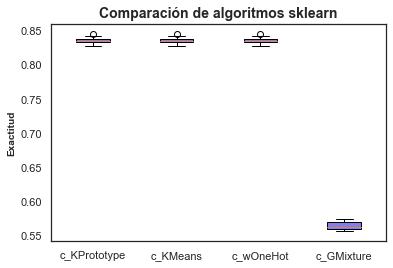

In [1376]:
# Configuración del área gráfica
fig, ax1 = plt.subplots(figsize=(6, 4))
sns.set_style("whitegrid")
sns.set_context("paper",font_scale=0.95,rc={"lines.linewidth": 1})
ax1.set_title("Comparación de algoritmos sklearn",fontweight ="bold", fontsize="14")
ax1.set_ylabel("Exactitud",fontweight ="bold", fontsize="10")
plt.boxplot(results, labels=names,patch_artist=True,
            boxprops=dict(facecolor=(0.0, 0.0, 0.9, 0.5)),
            whiskerprops=dict(ls="dashed"),widths=0.4)
plt.show()

Se evalúa la clasificación del array de test para los tres algoritmos. Para ello se usa la matriz de confusión y el reporte de clasificación que provee **Scikit Learn**.

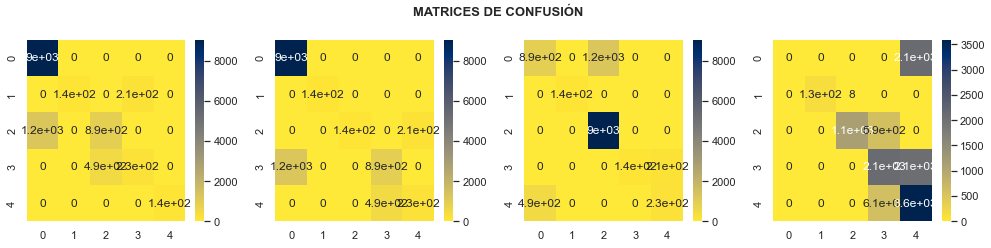

In [1379]:
sns.set(rc={'figure.figsize':(14,3.5)})
sns.set_style("white")
fig,axes = plt.subplots(1,4)
fig.suptitle('MATRICES DE CONFUSIÓN',fontweight ="bold", fontsize="13")

i=0
for name in clusters:
    cm = confusion_matrix(Y_test[i], Y_predict[i],labels=[0,1,2,3,4])
    sns.heatmap(cm, annot=True,ax=axes[i],cmap=cmap)
    i+=1
    
fig.tight_layout()
plt.show()

In [1380]:
print("\033[1mREPORTE DE CLASIFICACIÓN\033[0m")
i=0
for name in clusters:
    print("\033[4m"+ name + "\033[0m")
    print(classification_report(Y_test[i], Y_predict[i]))
    i+=1

REPORTE DE CLASIFICACIÓN
c_KPrototype
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94      9032
         1.0       1.00      0.40      0.57       344
         2.0       0.65      0.42      0.51      2124
         3.0       0.53      0.32      0.40       721
         4.0       1.00      1.00      1.00       135

    accuracy                           0.84     12356
   macro avg       0.81      0.63      0.68     12356
weighted avg       0.82      0.84      0.82     12356

c_KMeans
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94      9032
         1.0       1.00      1.00      1.00       135
         2.0       1.00      0.40      0.57       344
         3.0       0.65      0.42      0.51      2124
         4.0       0.53      0.32      0.40       721

    accuracy                           0.84     12356
   macro avg       0.81      0.63      0.68     12356
weighted avg       0.82      0

### Dataset agrupado
Se verifica la exactitud para los cuatro modelos entrenados con este dataset. 

In [1165]:
ds_group.head()

,cases,deaths,popData2019,c_KMeans,c_GMixture,c_FCM
countryterritoryCode,,,,,,
ABW,532171,5112,106310.0,0,0,4
AFG,7843873,288858,38041757.0,0,0,4
AGO,1482574,36783,31825299.0,0,0,4
AIA,1809,0,14872.0,0,0,4
ALB,4634190,108352,2862427.0,0,0,4


Dividimos el dataset en un array de atributos (x) y un array de la clase de salida (y)

In [1186]:
ds_group=ds_group.reset_index()
ds_group[code] = le.fit_transform(ds_group[code])
array = ds_group.values
x=array[:,1:4]
y=[]
# se crea un array y para cada algoritmo
for j in range(-3,0):
    y.append(return_column(array,j).reshape(-1,1))
ds_group[code] = le.inverse_transform(ds_group[code])

# Normalización de los atributos de entrada
norm_x = MinMaxScaler() # El rango por defecto de esta función es [0, 1]
x_fit = norm_x.fit(x)
x = x_fit.transform(x)

In [1189]:
clusters=ds_group.columns[5:]

Se clasifica usando **LogisticRegression** y separando los datos en 80% (X_train, Y_train) de datos para entrenar y 20% para test (X_test, Y_test).

In [1192]:
class_model=LogisticRegression()

In [1355]:
results = []
names = []
Y_predict=[]
Y_test=[]
i=0
print("\033[1m{:<15} {:<15} {:<15}".format("Algoritmo","Train Acc","Test Acc\033[0m"))
for name in clusters:
    X_train, X_test, y_train,y_test=train_test_split(x, y[i], test_size=0.2, random_state=42, shuffle=True)
    Y_test.append(y_test.reshape(1,-1)[0])
    names.append(name)
    kfold = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)
    # Validación cruzada k-fold
    cv_results = cross_val_score(class_model,X_train,y_train,cv=kfold,scoring="accuracy")
    results.append(cv_results)
    # Validación cruzada simple
    class_model.fit(X_train,y_train)
    Y_predict.append(class_model.predict(X_test))
    val_results = class_model.score(X_test,y_test) # exactitud de la predicción
    print ("{:<15} {:<15.5f} {:<15.5f}".format(name,cv_results.mean(),val_results))
    i+=1

Algoritmo       Train Acc       Test Acc   
c_KMeans        0.97647         1.00000        
c_GMixture      0.97647         1.00000        
c_FCM           0.88787         0.86047        


Se realiza la comparación gráfica de los cuatro algoritmos.

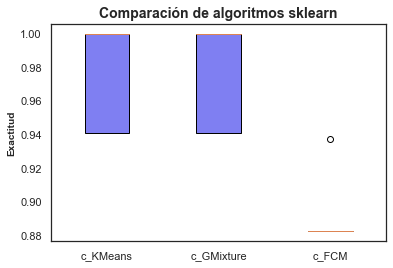

In [1356]:
# Configuración del área gráfica
fig, ax1 = plt.subplots(figsize=(6, 4))
sns.set_style("whitegrid")
sns.set_context("paper",font_scale=0.95,rc={"lines.linewidth": 1})
ax1.set_title("Comparación de algoritmos sklearn",fontweight ="bold", fontsize="14")
ax1.set_ylabel("Exactitud",fontweight ="bold", fontsize="10")
plt.boxplot(results, labels=names,patch_artist=True,
            boxprops=dict(facecolor=(0.0, 0.0, 0.9, 0.5)),
            whiskerprops=dict(ls="dashed"),widths=0.4)
plt.show()

Se evalúa la clasificación del array de test para los tres algoritmos. Para ello se usa la matriz de confusión y el reporte de clasificación que provee **Scikit Learn**.

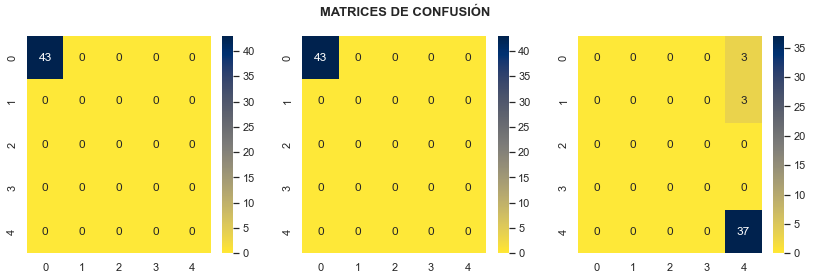

In [1367]:
sns.set(rc={'figure.figsize':(14,4)})
sns.set_style("white")
fig,axes = plt.subplots(1,3)
fig.suptitle('MATRICES DE CONFUSIÓN',fontweight ="bold", fontsize="13")

i=0
for name in clusters:
    cm = confusion_matrix(Y_test[i], Y_predict[i],labels=[0,1,2,3,4])
    sns.heatmap(cm, annot=True,ax=axes[i],cmap=cmap)
    i+=1

In [1369]:
print("\033[1mREPORTE DE CLASIFICACIÓN\033[0m")
i=0
for name in clusters:
    print("\033[4m"+ name + "\033[0m")
    print(classification_report(Y_test[i], Y_predict[i]))
    i+=1

REPORTE DE CLASIFICACIÓN
c_KMeans
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        43

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43

c_GMixture
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        43

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43

c_FCM
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.00      0.00      0.00         3
         4.0       0.86      1.00      0.92        37

    accuracy                           0.86        43
   macro avg       0.29      0.33      0.31        43
weighted avg       0.74      0.86      0.80        43



## Conclusiones
- Se realizaron varios análisis de clustering para determinar el impacto del COVID a nivel global. Los algoritmos con resultados más óptimos son aquellos basados en series temporales que permiten un mayor ajuste.
- Al agrupar los datos de los países y reducir a una fila por país el análisis no resulta útil, la clasificación es demasiado generalista.
- Los mejores resultados se obtienen con el algoritmo basado en series temporales
- Al añadir parámetros que influyen también en la evolución de la enfermedad se determina que

<!--bibtex

@article{OWID-GH,
  author    = {OurWorldInData, },
  Title     = {covid-19-data},
  year      = {2022},
  url       = "https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv"
}

@article{CSSE-JHU,
  author    = {CSSE JHU, },
  Title     = {COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University},
  year      = {2022},
  url       = "https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports"
}

@article{pd-merge,
  author    = {Pandas, },
  Title     = {pandas.DataFrame.merge},
  year      = {2022},
  url       = "https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html"
}

@article{COVID-NEGATIVE,
  author    = {ScienceDirect, },
  Title     = {Dataset of COVID-19 outbreak and potential predictive features in the USA},
  year      = {2021},
  url       = "https://www.sciencedirect.com/science/article/pii/S2352340921006429"
}

@article{seaborn-plot:2021,
  author    = {Seaborn,},
  Title     = {Plotting with categorical data},
  year      = {2021},
  url       = "https://seaborn.pydata.org/tutorial/categorical.html"
}

@article{GPD:2022,
  author    = {Geopandas,},
  Title     = {Mapping and Plotting Tools},
  year      = {2022},
  url       = "https://geopandas.org/en/stable/docs/user_guide/mapping.html"
}

@article{MPL-CR,
  author    = {Matplotlib,},
  Title     = {Color Reference},
  year      = {2022},
  url       = "https://matplotlib.org/stable/tutorials/colors/colormaps.html"
}

@article{LOST,
  author    = {LOST,},
  Title     = {Line Graph with Labels at the Beginning or End of Lines},
  year      = {2022},
  url       = "https://lost-stats.github.io/Presentation/Figures/line_graph_with_labels_at_the_beginning_or_end.html"
}

@article{SKL-KM,
  author    = {Scikitlearn,},
  Title     = {sklearn.cluster.KMeans},
  year      = {2022},
  url       = "https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html"
}

@article{SKL-GM,
  author    = {Scikitlearn,},
  Title     = {sklearn.cluster.GaussianMixture},
  year      = {2022},
  url       = "https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html"
}

@article{SKL-DBS,
  author    = {Scikitlearn,},
  Title     = {sklearn.cluster.DBSCAN},
  year      = {2022},
  url       = "https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html"
}

@article{CV19-IncidentRate,
  author    = {Sanitaria,},
  Title     = {¿Qué es la incidencia acumulada?},
  year      = {2022},
  url       = "https://www.redaccionmedica.com/recursos-salud/faqs-covid19/que-es-la-incidencia-acumulada-covid"
}

@article{CV19-FatalitytRate,
  author    = {OMS,},
  Title     = {Estimación de la mortalidad de la COVID-19},
  year      = {2020},
  url       = "https://www.redaccionmedica.com/recursos-salud/faqs-covid19/que-es-la-incidencia-acumulada-covid"
}

@book{TSL,
  author    = {tsLearn,},
  Title     = {tslearn’s documentation},
  year      = {2022},
  url       = "https://tslearn.readthedocs.io/en/stable/"
}
@book{KP,
  author    = {PyPi,},
  Title     = {kmodes},
  year      = {2022},
  url       = "https://pypi.org/project/kmodes/#huang97"
}

@article{KGL-TS,
  author    = {Kaggle,},
  Title     = {Introduction to Time Series Clustering},
  year      = {2021},
  url       = "https://www.kaggle.com/izzettunc/introduction-to-time-series-clustering"
}

@article{FCM,
  author    = {PyPI,},
  Title     = {fuzzy-c-means},
  year      = {2022},
  url       = "https://pypi.org/project/fuzzy-c-means/"
}

@article{TTSDUtil,
  author    = {tslearn,},
  Title     = {tslearn-utils-to-time-series-dataset},
  year      = {2022},
  url       = "https://tslearn.readthedocs.io/en/stable/gen_modules/utils/tslearn.utils.to_time_series_dataset.html#tslearn-utils-to-time-series-dataset"
}

@article{PH-FCM,
  author    = {SciKit-Fuzzy,},
  Title     = {Fuzzy c-means clustering},
  year      = {2022},
  url       = "https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_cmeans.html"
}

-->

# References

<a name="cite-pd-merge"/><sup>[^](#ref-1) </sup>Pandas, . 2022. _pandas.DataFrame.merge_. [URL](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html)

<a name="cite-OWID-GH"/><sup>[^](#ref-2) </sup>OurWorldInData, . 2022. _covid-19-data_. [URL](https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv)

<a name="cite-CSSE-JHU"/><sup>[^](#ref-3) </sup>CSSE JHU, . 2022. _COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University_. [URL](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports)

<a name="cite-GPD:2022"/><sup>[^](#ref-4) </sup>Geopandas,. 2022. _Mapping and Plotting Tools_. [URL](https://geopandas.org/en/stable/docs/user_guide/mapping.html)

<a name="cite-COVID-NEGATIVE"/><sup>[^](#ref-5) </sup>ScienceDirect, . 2021. _Dataset of COVID-19 outbreak and potential predictive features in the USA_. [URL](https://www.sciencedirect.com/science/article/pii/S2352340921006429)

<a name="cite-LOST"/><sup>[^](#ref-6) </sup>LOST,. 2022. _Line Graph with Labels at the Beginning or End of Lines_. [URL](https://lost-stats.github.io/Presentation/Figures/line_graph_with_labels_at_the_beginning_or_end.html)

<a name="cite-seaborn-plot:2021"/><sup>[^](#ref-7) </sup>Seaborn,. 2021. _Plotting with categorical data_. [URL](https://seaborn.pydata.org/tutorial/categorical.html)

<a name="cite-MPL-CR"/><sup>[^](#ref-8) </sup>Matplotlib,. 2022. _Color Reference_. [URL](https://matplotlib.org/stable/tutorials/colors/colormaps.html)

<a name="cite-KP"/><sup>[^](#ref-9) </sup>PyPi,. 2022. _kmodes_. [URL](https://pypi.org/project/kmodes/#huang97)

<a name="cite-SKL-KM"/><sup>[^](#ref-10) </sup>Scikitlearn,. 2022. _sklearn.cluster.KMeans_. [URL](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

<a name="cite-SKL-GM"/><sup>[^](#ref-11) </sup>Scikitlearn,. 2022. _sklearn.cluster.GaussianMixture_. [URL](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)

<a name="cite-CV19-IncidentRate"/><sup>[^](#ref-12) </sup>Sanitaria,. 2022. _¿Qué es la incidencia acumulada?_. [URL](https://www.redaccionmedica.com/recursos-salud/faqs-covid19/que-es-la-incidencia-acumulada-covid)

<a name="cite-CV19-FatalitytRate"/><sup>[^](#ref-13) </sup>OMS,. 2020. _Estimación de la mortalidad de la COVID-19_. [URL](https://www.redaccionmedica.com/recursos-salud/faqs-covid19/que-es-la-incidencia-acumulada-covid)

<a name="cite-PH-FCM"/><sup>[^](#ref-14) </sup>SciKit-Fuzzy,. 2022. _Fuzzy c-means clustering_. [URL](https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_cmeans.html)

<a name="cite-TSL"/><sup>[^](#ref-15) </sup>tsLearn,. 2022. _tslearn’s documentation_. [URL](https://tslearn.readthedocs.io/en/stable/)

<a name="cite-KGL-TS"/><sup>[^](#ref-16) </sup>Kaggle,. 2021. _Introduction to Time Series Clustering_. [URL](https://www.kaggle.com/izzettunc/introduction-to-time-series-clustering)

<a name="cite-TTSDUtil"/><sup>[^](#ref-17) </sup>tslearn,. 2022. _tslearn-utils-to-time-series-dataset_. [URL](https://tslearn.readthedocs.io/en/stable/gen_modules/utils/tslearn.utils.to_time_series_dataset.html#tslearn-utils-to-time-series-dataset)

